# Generador de rostros artificiales mediante redes adversativas

En este se usara imagenes de menor tamaño (128x128 -> 32x32 )

En una red adversaria se tienen dos modelos (que pueden ser Redes Neuronales o Convolucionales) compitiendo: un Generador y un Discriminador.

Se genera un primer modelo que llamaremos Discriminador para que sea capaz de reconocer rostros humanos. Este discriminador será simplemente un clasificador,que buscara indicar si una imagen es real o falsa

Se genera un segundo modelo, que llamaremos Generador y nuestro objetivo es entrenarlo para que sea capaz de tomar una entrada aleatoria y a la salida generar algo muy parecido a una imagen de un rostro.

La idea es entrenar esos dos modelos simultáneamente buscando que al final sea el Generador el vencedor en esta competencia.



In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from keras.preprocessing.image import img_to_array

### Funcion para carga y visualizar datos

In [2]:
def cargar_datos(dataset, TAM_IMG):
    print('Creando set de entrenamiento...')
    filelist = os.listdir(dataset)

    n_imgs = len(filelist)
    x_train = np.zeros((n_imgs,TAM_IMG,TAM_IMG,3))

    for i in range(n_imgs):
        direcion = str(dataset)+ "\\" + str(filelist[i])
        imagen = cv2.imread(direcion,1)
        imagen = cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB)
        imagen = cv2.resize(imagen, dsize=(TAM_IMG, TAM_IMG))
        imagen = (imagen - 127.5)/127.5 #para dejarlo entre -1 y 1
        x_train[i,:] = imagen
    print('¡Listo!')

    return x_train

def visualizar_imagen(imagen):
    imagen = imagen * 0.5 + 0.5 #para pasarlo de 0 a 1
    plt.imshow(imagen)
    plt.show()


### Funcion para la creacion de los modelos

In [3]:
from keras.models import Sequential, Model
from keras.layers import Dense, Reshape, Conv2DTranspose, BatchNormalization, Conv2D, LeakyReLU, Flatten, Input, UpSampling2D
from keras.layers.core import Activation

In [4]:
def crear_generador(TAM_ENTRADA, TAM_IMG):
    modelo = Sequential(name = "Generador")
    
    modelo.add(Dense(4*4*3, use_bias=False, input_shape=(TAM_ENTRADA,)))
    modelo.add(Reshape((4,4,3)))
    #Tamaño resultante: 4x4x3
    
    modelo.add(Conv2DTranspose(128, 2, strides=1,padding='same',kernel_initializer='he_normal',use_bias=False))
    #Tamaño resultante: 4x4x128
    
    modelo.add(Conv2DTranspose(64, 4, strides=2,padding='same',kernel_initializer='he_normal',use_bias=False))
    #modelo.add(Conv2DTranspose(64, 2, strides=1,padding='same',kernel_initializer='he_normal',use_bias=False))
    modelo.add(BatchNormalization())
    #Tamaño resultante: 8x8x64
    
    modelo.add(Conv2DTranspose(32, 4, strides=2,padding='same',kernel_initializer='he_normal',use_bias=False))
    #modelo.add(Conv2DTranspose(32, 2, strides=1,padding='same',kernel_initializer='he_normal',use_bias=False))
    modelo.add(BatchNormalization())
    #Tamaño resultante: 16x16x32
    
    modelo.add(Conv2DTranspose(16, 4, strides=2,padding='same',kernel_initializer='he_normal',use_bias=False))
    #modelo.add(Conv2DTranspose(16, 2, strides=1,padding='same',kernel_initializer='he_normal',use_bias=False))
    modelo.add(BatchNormalization())
    #Tamaño resultante: 32x32x16
    
    modelo.add(Conv2D(3, 2, strides = 1, padding='same',kernel_initializer='he_normal',use_bias=False))
    modelo.add(Conv2D(3, 2, strides = 1, padding='same',kernel_initializer='he_normal',use_bias=False))
    modelo.add(Conv2D(3, 2, strides = 1, padding = 'same',activation = 'tanh'))
    #Tamaño resultante: 32x32x3
    
    #modelo.compile(optimizer="Adam", loss="binary_crossentropy")

    return modelo



In [5]:
def crear_discriminador(TAM_IMG):
    
    modelo = Sequential(name = "Discriminador")

    modelo.add(Conv2D(32, 4, strides=2, padding='same',kernel_initializer='he_normal', input_shape=(TAM_IMG,TAM_IMG,3)))
    modelo.add(BatchNormalization())
    modelo.add(LeakyReLU())
    #16x16x32

    modelo.add(Conv2D(64, 4, strides=2, padding='same',kernel_initializer='he_normal'))
    modelo.add(BatchNormalization())
    modelo.add(LeakyReLU())
    #8x8x64
    
    modelo.add(Conv2D(128, 4, strides=1, padding='same',kernel_initializer='he_normal'))
    modelo.add(BatchNormalization())
    modelo.add(LeakyReLU())
    #4x4x128
    
    modelo.add(Flatten())
    modelo.add(Dense(100, activation='LeakyReLU'))
    modelo.add(Dense(1, activation='sigmoid'))

    modelo.compile(optimizer="Adam", loss="binary_crossentropy")

    return modelo

In [6]:
def crear_GAN(generador, discriminador):
    modelo = Sequential(name = "GAN")
    modelo.add(generador)
    discriminador.trainable = False
    modelo.add(discriminador)
    modelo.compile(optimizer="Adam", loss="binary_crossentropy")

    return modelo


### Carga de datos y creacion de modelos

In [7]:
TAM_ENTRADA = 100
TAM_IMG = 32

In [8]:
x_train = cargar_datos("dataset1", TAM_IMG)

Creando set de entrenamiento...
¡Listo!


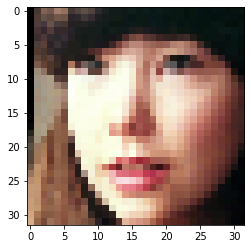

In [9]:
visualizar_imagen(x_train[12])

In [10]:
generador = crear_generador(TAM_ENTRADA, TAM_IMG)
# generador.summary()
print("")
print("")
discriminador = crear_discriminador(TAM_IMG)
# discriminador.summary()
print("")
print("")
gan = crear_GAN(generador, discriminador)
# gan.summary()

### Entrenamiento

En el caso de las Redes Adversarias debemos llevar a cabo estos pasos:

1. “Descongelar” los coeficientes del Discriminador
2. Entrenar solo el Discriminador con imagenes falsas y reales
3. “Congelar” los coeficientes del Discriminador
4. Entrenar la GAN, al estar congelado el discriminador únicamente se entrenara el Generador
5. Repetir los pasos 1 a 4 por el número de iteraciones que se vayan a usar el entrenamiento

In [11]:
TAM_LOTE = 150 
N_ITS = 5000
import time

Comenzando Epoca 1... Fin
Tiempo transcurrido:  2.663485288619995
prediccion de ruido:  tf.Tensor([[0.168636]], shape=(1, 1), dtype=float32)
Comenzando Epoca 2... Fin
Tiempo transcurrido:  0.7498414516448975
prediccion de ruido:  tf.Tensor([[0.10192609]], shape=(1, 1), dtype=float32)
Comenzando Epoca 3... Fin
Tiempo transcurrido:  0.7962400913238525
prediccion de ruido:  tf.Tensor([[0.79596996]], shape=(1, 1), dtype=float32)
Comenzando Epoca 4... Fin
Tiempo transcurrido:  0.7862462997436523
prediccion de ruido:  tf.Tensor([[0.15298235]], shape=(1, 1), dtype=float32)
Comenzando Epoca 5... Fin
Tiempo transcurrido:  0.7530097961425781
prediccion de ruido:  tf.Tensor([[0.14461547]], shape=(1, 1), dtype=float32)
Comenzando Epoca 6... Fin
Tiempo transcurrido:  0.7692229747772217
prediccion de ruido:  tf.Tensor([[0.34661266]], shape=(1, 1), dtype=float32)
Comenzando Epoca 7... Fin
Tiempo transcurrido:  0.8142712116241455
prediccion de ruido:  tf.Tensor([[0.54769397]], shape=(1, 1), dtype=floa

Comenzando Epoca 40... Fin
Tiempo transcurrido:  0.8436610698699951
prediccion de ruido:  tf.Tensor([[0.08587632]], shape=(1, 1), dtype=float32)
Comenzando Epoca 41... Fin
Tiempo transcurrido:  0.771047830581665
prediccion de ruido:  tf.Tensor([[0.04780567]], shape=(1, 1), dtype=float32)
Comenzando Epoca 42... Fin
Tiempo transcurrido:  0.801058292388916
prediccion de ruido:  tf.Tensor([[0.00590754]], shape=(1, 1), dtype=float32)
Comenzando Epoca 43... Fin
Tiempo transcurrido:  0.7680110931396484
prediccion de ruido:  tf.Tensor([[0.00101519]], shape=(1, 1), dtype=float32)
Comenzando Epoca 44... Fin
Tiempo transcurrido:  0.7526154518127441
prediccion de ruido:  tf.Tensor([[0.00357193]], shape=(1, 1), dtype=float32)
Comenzando Epoca 45... Fin
Tiempo transcurrido:  0.7732160091400146
prediccion de ruido:  tf.Tensor([[0.01957333]], shape=(1, 1), dtype=float32)
Comenzando Epoca 46... Fin
Tiempo transcurrido:  0.749812126159668
prediccion de ruido:  tf.Tensor([[0.00394619]], shape=(1, 1), dty

Comenzando Epoca 79... Fin
Tiempo transcurrido:  0.7544183731079102
prediccion de ruido:  tf.Tensor([[0.02013516]], shape=(1, 1), dtype=float32)
Comenzando Epoca 80... Fin
Tiempo transcurrido:  0.7634122371673584
prediccion de ruido:  tf.Tensor([[0.03983298]], shape=(1, 1), dtype=float32)
Comenzando Epoca 81... Fin
Tiempo transcurrido:  0.7886629104614258
prediccion de ruido:  tf.Tensor([[0.03506905]], shape=(1, 1), dtype=float32)
Comenzando Epoca 82... Fin
Tiempo transcurrido:  0.7900497913360596
prediccion de ruido:  tf.Tensor([[0.0086925]], shape=(1, 1), dtype=float32)
Comenzando Epoca 83... Fin
Tiempo transcurrido:  0.8126504421234131
prediccion de ruido:  tf.Tensor([[0.10514605]], shape=(1, 1), dtype=float32)
Comenzando Epoca 84... Fin
Tiempo transcurrido:  0.7538125514984131
prediccion de ruido:  tf.Tensor([[0.2435509]], shape=(1, 1), dtype=float32)
Comenzando Epoca 85... Fin
Tiempo transcurrido:  0.7562437057495117
prediccion de ruido:  tf.Tensor([[0.01944399]], shape=(1, 1), dt

Comenzando Epoca 118... Fin
Tiempo transcurrido:  0.751812219619751
prediccion de ruido:  tf.Tensor([[0.00144207]], shape=(1, 1), dtype=float32)
Comenzando Epoca 119... Fin
Tiempo transcurrido:  0.8386533260345459
prediccion de ruido:  tf.Tensor([[0.01390472]], shape=(1, 1), dtype=float32)
Comenzando Epoca 120... Fin
Tiempo transcurrido:  0.8216443061828613
prediccion de ruido:  tf.Tensor([[0.00744492]], shape=(1, 1), dtype=float32)
Comenzando Epoca 121... Fin
Tiempo transcurrido:  0.7814357280731201
prediccion de ruido:  tf.Tensor([[0.08655962]], shape=(1, 1), dtype=float32)
Comenzando Epoca 122... Fin
Tiempo transcurrido:  0.7518124580383301
prediccion de ruido:  tf.Tensor([[0.06156823]], shape=(1, 1), dtype=float32)
Comenzando Epoca 123... Fin
Tiempo transcurrido:  0.7868449687957764
prediccion de ruido:  tf.Tensor([[0.28482124]], shape=(1, 1), dtype=float32)
Comenzando Epoca 124... Fin
Tiempo transcurrido:  0.7888453006744385
prediccion de ruido:  tf.Tensor([[0.01142102]], shape=(1

Comenzando Epoca 157... Fin
Tiempo transcurrido:  0.7708141803741455
prediccion de ruido:  tf.Tensor([[0.1644035]], shape=(1, 1), dtype=float32)
Comenzando Epoca 158... Fin
Tiempo transcurrido:  0.7680113315582275
prediccion de ruido:  tf.Tensor([[0.02959776]], shape=(1, 1), dtype=float32)
Comenzando Epoca 159... Fin
Tiempo transcurrido:  0.7696096897125244
prediccion de ruido:  tf.Tensor([[0.33377486]], shape=(1, 1), dtype=float32)
Comenzando Epoca 160... Fin
Tiempo transcurrido:  0.7538127899169922
prediccion de ruido:  tf.Tensor([[0.15206051]], shape=(1, 1), dtype=float32)
Comenzando Epoca 161... Fin
Tiempo transcurrido:  0.7582216262817383
prediccion de ruido:  tf.Tensor([[0.09102395]], shape=(1, 1), dtype=float32)
Comenzando Epoca 162... Fin
Tiempo transcurrido:  0.8082704544067383
prediccion de ruido:  tf.Tensor([[0.32765695]], shape=(1, 1), dtype=float32)
Comenzando Epoca 163... Fin
Tiempo transcurrido:  0.7654051780700684
prediccion de ruido:  tf.Tensor([[0.28176787]], shape=(1

Comenzando Epoca 196... Fin
Tiempo transcurrido:  0.7644050121307373
prediccion de ruido:  tf.Tensor([[0.11238387]], shape=(1, 1), dtype=float32)
Comenzando Epoca 197... Fin
Tiempo transcurrido:  0.7800049781799316
prediccion de ruido:  tf.Tensor([[0.15088841]], shape=(1, 1), dtype=float32)
Comenzando Epoca 198... Fin
Tiempo transcurrido:  0.7644047737121582
prediccion de ruido:  tf.Tensor([[0.2719437]], shape=(1, 1), dtype=float32)
Comenzando Epoca 199... Fin
Tiempo transcurrido:  0.7800052165985107
prediccion de ruido:  tf.Tensor([[0.27691615]], shape=(1, 1), dtype=float32)
Comenzando Epoca 200... Fin
Tiempo transcurrido:  0.8892054557800293
prediccion de ruido:  tf.Tensor([[0.11515906]], shape=(1, 1), dtype=float32)
Comenzando Epoca 201... Fin
Tiempo transcurrido:  0.7644050121307373
prediccion de ruido:  tf.Tensor([[0.17034528]], shape=(1, 1), dtype=float32)
Comenzando Epoca 202... Fin
Tiempo transcurrido:  0.795604944229126
prediccion de ruido:  tf.Tensor([[0.38122055]], shape=(1,

Comenzando Epoca 235... Fin
Tiempo transcurrido:  0.7800047397613525
prediccion de ruido:  tf.Tensor([[0.31608406]], shape=(1, 1), dtype=float32)
Comenzando Epoca 236... Fin
Tiempo transcurrido:  0.795604944229126
prediccion de ruido:  tf.Tensor([[0.14121208]], shape=(1, 1), dtype=float32)
Comenzando Epoca 237... Fin
Tiempo transcurrido:  0.748805046081543
prediccion de ruido:  tf.Tensor([[0.16948754]], shape=(1, 1), dtype=float32)
Comenzando Epoca 238... Fin
Tiempo transcurrido:  0.7488048076629639
prediccion de ruido:  tf.Tensor([[0.14198095]], shape=(1, 1), dtype=float32)
Comenzando Epoca 239... Fin
Tiempo transcurrido:  0.8112051486968994
prediccion de ruido:  tf.Tensor([[0.04138422]], shape=(1, 1), dtype=float32)
Comenzando Epoca 240... Fin
Tiempo transcurrido:  0.7332046031951904
prediccion de ruido:  tf.Tensor([[0.23836449]], shape=(1, 1), dtype=float32)
Comenzando Epoca 241... Fin
Tiempo transcurrido:  0.7644050121307373
prediccion de ruido:  tf.Tensor([[0.11099017]], shape=(1,

Comenzando Epoca 274... Fin
Tiempo transcurrido:  0.7644047737121582
prediccion de ruido:  tf.Tensor([[0.03278589]], shape=(1, 1), dtype=float32)
Comenzando Epoca 275... Fin
Tiempo transcurrido:  0.748805046081543
prediccion de ruido:  tf.Tensor([[0.04072133]], shape=(1, 1), dtype=float32)
Comenzando Epoca 276... Fin
Tiempo transcurrido:  0.7644047737121582
prediccion de ruido:  tf.Tensor([[0.05268294]], shape=(1, 1), dtype=float32)
Comenzando Epoca 277... Fin
Tiempo transcurrido:  0.7488048076629639
prediccion de ruido:  tf.Tensor([[0.06300771]], shape=(1, 1), dtype=float32)
Comenzando Epoca 278... Fin
Tiempo transcurrido:  0.7644050121307373
prediccion de ruido:  tf.Tensor([[0.11753628]], shape=(1, 1), dtype=float32)
Comenzando Epoca 279... Fin
Tiempo transcurrido:  0.7840051651000977
prediccion de ruido:  tf.Tensor([[0.01551861]], shape=(1, 1), dtype=float32)
Comenzando Epoca 280... Fin
Tiempo transcurrido:  0.7800052165985107
prediccion de ruido:  tf.Tensor([[0.06933016]], shape=(1

Comenzando Epoca 313... Fin
Tiempo transcurrido:  0.786414623260498
prediccion de ruido:  tf.Tensor([[0.00419116]], shape=(1, 1), dtype=float32)
Comenzando Epoca 314... Fin
Tiempo transcurrido:  0.7530093193054199
prediccion de ruido:  tf.Tensor([[0.00366741]], shape=(1, 1), dtype=float32)
Comenzando Epoca 315... Fin
Tiempo transcurrido:  0.7850131988525391
prediccion de ruido:  tf.Tensor([[0.0011538]], shape=(1, 1), dtype=float32)
Comenzando Epoca 316... Fin
Tiempo transcurrido:  0.7694125175476074
prediccion de ruido:  tf.Tensor([[0.01356956]], shape=(1, 1), dtype=float32)
Comenzando Epoca 317... Fin
Tiempo transcurrido:  0.7538125514984131
prediccion de ruido:  tf.Tensor([[0.00845581]], shape=(1, 1), dtype=float32)
Comenzando Epoca 318... Fin
Tiempo transcurrido:  0.7698142528533936
prediccion de ruido:  tf.Tensor([[0.0330458]], shape=(1, 1), dtype=float32)
Comenzando Epoca 319... Fin
Tiempo transcurrido:  0.7844140529632568
prediccion de ruido:  tf.Tensor([[0.27332324]], shape=(1, 

Comenzando Epoca 352... Fin
Tiempo transcurrido:  0.7644050121307373
prediccion de ruido:  tf.Tensor([[0.66647065]], shape=(1, 1), dtype=float32)
Comenzando Epoca 353... Fin
Tiempo transcurrido:  0.7768058776855469
prediccion de ruido:  tf.Tensor([[0.01001626]], shape=(1, 1), dtype=float32)
Comenzando Epoca 354... Fin
Tiempo transcurrido:  0.7644050121307373
prediccion de ruido:  tf.Tensor([[0.00165233]], shape=(1, 1), dtype=float32)
Comenzando Epoca 355... Fin
Tiempo transcurrido:  0.7644045352935791
prediccion de ruido:  tf.Tensor([[0.00156724]], shape=(1, 1), dtype=float32)
Comenzando Epoca 356... Fin
Tiempo transcurrido:  0.7902178764343262
prediccion de ruido:  tf.Tensor([[0.00044802]], shape=(1, 1), dtype=float32)
Comenzando Epoca 357... Fin
Tiempo transcurrido:  0.74721360206604
prediccion de ruido:  tf.Tensor([[1.4440642e-05]], shape=(1, 1), dtype=float32)
Comenzando Epoca 358... Fin
Tiempo transcurrido:  0.7832238674163818
prediccion de ruido:  tf.Tensor([[0.00347188]], shape=

Comenzando Epoca 391... Fin
Tiempo transcurrido:  0.7508049011230469
prediccion de ruido:  tf.Tensor([[0.0008204]], shape=(1, 1), dtype=float32)
Comenzando Epoca 392... Fin
Tiempo transcurrido:  0.8140087127685547
prediccion de ruido:  tf.Tensor([[0.00043246]], shape=(1, 1), dtype=float32)
Comenzando Epoca 393... Fin
Tiempo transcurrido:  0.7654049396514893
prediccion de ruido:  tf.Tensor([[0.06127584]], shape=(1, 1), dtype=float32)
Comenzando Epoca 394... Fin
Tiempo transcurrido:  0.7644047737121582
prediccion de ruido:  tf.Tensor([[0.00075185]], shape=(1, 1), dtype=float32)
Comenzando Epoca 395... Fin
Tiempo transcurrido:  0.7820053100585938
prediccion de ruido:  tf.Tensor([[0.02443287]], shape=(1, 1), dtype=float32)
Comenzando Epoca 396... Fin
Tiempo transcurrido:  0.8112051486968994
prediccion de ruido:  tf.Tensor([[0.00010489]], shape=(1, 1), dtype=float32)
Comenzando Epoca 397... Fin
Tiempo transcurrido:  0.7644050121307373
prediccion de ruido:  tf.Tensor([[0.00570816]], shape=(1

Comenzando Epoca 430... Fin
Tiempo transcurrido:  0.7704129219055176
prediccion de ruido:  tf.Tensor([[0.03851265]], shape=(1, 1), dtype=float32)
Comenzando Epoca 431... Fin
Tiempo transcurrido:  0.7688138484954834
prediccion de ruido:  tf.Tensor([[0.01736146]], shape=(1, 1), dtype=float32)
Comenzando Epoca 432... Fin
Tiempo transcurrido:  0.752410888671875
prediccion de ruido:  tf.Tensor([[0.00476021]], shape=(1, 1), dtype=float32)
Comenzando Epoca 433... Fin
Tiempo transcurrido:  0.7892251014709473
prediccion de ruido:  tf.Tensor([[0.01152262]], shape=(1, 1), dtype=float32)
Comenzando Epoca 434... Fin
Tiempo transcurrido:  0.7800123691558838
prediccion de ruido:  tf.Tensor([[0.01431495]], shape=(1, 1), dtype=float32)
Comenzando Epoca 435... Fin
Tiempo transcurrido:  0.7566156387329102
prediccion de ruido:  tf.Tensor([[0.0001043]], shape=(1, 1), dtype=float32)
Comenzando Epoca 436... Fin
Tiempo transcurrido:  0.7690258026123047
prediccion de ruido:  tf.Tensor([[0.02023736]], shape=(1,

Comenzando Epoca 469... Fin
Tiempo transcurrido:  0.7700114250183105
prediccion de ruido:  tf.Tensor([[0.0018765]], shape=(1, 1), dtype=float32)
Comenzando Epoca 470... Fin
Tiempo transcurrido:  0.752009391784668
prediccion de ruido:  tf.Tensor([[0.01377937]], shape=(1, 1), dtype=float32)
Comenzando Epoca 471... Fin
Tiempo transcurrido:  0.7700114250183105
prediccion de ruido:  tf.Tensor([[0.0092923]], shape=(1, 1), dtype=float32)
Comenzando Epoca 472... Fin
Tiempo transcurrido:  0.750607967376709
prediccion de ruido:  tf.Tensor([[0.03024742]], shape=(1, 1), dtype=float32)
Comenzando Epoca 473... Fin
Tiempo transcurrido:  0.7554113864898682
prediccion de ruido:  tf.Tensor([[0.00163022]], shape=(1, 1), dtype=float32)
Comenzando Epoca 474... Fin
Tiempo transcurrido:  0.7686097621917725
prediccion de ruido:  tf.Tensor([[0.03418764]], shape=(1, 1), dtype=float32)
Comenzando Epoca 475... Fin
Tiempo transcurrido:  0.753411054611206
prediccion de ruido:  tf.Tensor([[0.00703669]], shape=(1, 1)

Comenzando Epoca 508... Fin
Tiempo transcurrido:  0.7712156772613525
prediccion de ruido:  tf.Tensor([[0.11078596]], shape=(1, 1), dtype=float32)
Comenzando Epoca 509... Fin
Tiempo transcurrido:  0.7672152519226074
prediccion de ruido:  tf.Tensor([[0.00461242]], shape=(1, 1), dtype=float32)
Comenzando Epoca 510... Fin
Tiempo transcurrido:  0.78501296043396
prediccion de ruido:  tf.Tensor([[0.0047929]], shape=(1, 1), dtype=float32)
Comenzando Epoca 511... Fin
Tiempo transcurrido:  0.8076572418212891
prediccion de ruido:  tf.Tensor([[0.02021214]], shape=(1, 1), dtype=float32)
Comenzando Epoca 512... Fin
Tiempo transcurrido:  0.7822170257568359
prediccion de ruido:  tf.Tensor([[0.00852385]], shape=(1, 1), dtype=float32)
Comenzando Epoca 513... Fin
Tiempo transcurrido:  0.786414384841919
prediccion de ruido:  tf.Tensor([[0.00676656]], shape=(1, 1), dtype=float32)
Comenzando Epoca 514... Fin
Tiempo transcurrido:  0.7674124240875244
prediccion de ruido:  tf.Tensor([[0.03104907]], shape=(1, 1

Comenzando Epoca 547... Fin
Tiempo transcurrido:  0.7870421409606934
prediccion de ruido:  tf.Tensor([[0.01696652]], shape=(1, 1), dtype=float32)
Comenzando Epoca 548... Fin
Tiempo transcurrido:  0.751410961151123
prediccion de ruido:  tf.Tensor([[0.00234637]], shape=(1, 1), dtype=float32)
Comenzando Epoca 549... Fin
Tiempo transcurrido:  0.7694127559661865
prediccion de ruido:  tf.Tensor([[6.969822e-05]], shape=(1, 1), dtype=float32)
Comenzando Epoca 550... Fin
Tiempo transcurrido:  0.7684125900268555
prediccion de ruido:  tf.Tensor([[0.01532158]], shape=(1, 1), dtype=float32)
Comenzando Epoca 551... Fin
Tiempo transcurrido:  0.7532141208648682
prediccion de ruido:  tf.Tensor([[0.00014731]], shape=(1, 1), dtype=float32)
Comenzando Epoca 552... Fin
Tiempo transcurrido:  0.7684123516082764
prediccion de ruido:  tf.Tensor([[0.00397223]], shape=(1, 1), dtype=float32)
Comenzando Epoca 553... Fin
Tiempo transcurrido:  0.7538127899169922
prediccion de ruido:  tf.Tensor([[0.00044557]], shape=

Comenzando Epoca 586... Fin
Tiempo transcurrido:  0.7644047737121582
prediccion de ruido:  tf.Tensor([[0.0004791]], shape=(1, 1), dtype=float32)
Comenzando Epoca 587... Fin
Tiempo transcurrido:  0.7498049736022949
prediccion de ruido:  tf.Tensor([[0.00216904]], shape=(1, 1), dtype=float32)
Comenzando Epoca 588... Fin
Tiempo transcurrido:  0.7800049781799316
prediccion de ruido:  tf.Tensor([[0.00308058]], shape=(1, 1), dtype=float32)
Comenzando Epoca 589... Fin
Tiempo transcurrido:  0.7684125900268555
prediccion de ruido:  tf.Tensor([[0.00082642]], shape=(1, 1), dtype=float32)
Comenzando Epoca 590... Fin
Tiempo transcurrido:  0.7800052165985107
prediccion de ruido:  tf.Tensor([[0.00687373]], shape=(1, 1), dtype=float32)
Comenzando Epoca 591... Fin
Tiempo transcurrido:  0.7488045692443848
prediccion de ruido:  tf.Tensor([[0.01426429]], shape=(1, 1), dtype=float32)
Comenzando Epoca 592... Fin
Tiempo transcurrido:  0.7644050121307373
prediccion de ruido:  tf.Tensor([[0.00038436]], shape=(1

Comenzando Epoca 625... Fin
Tiempo transcurrido:  0.7644045352935791
prediccion de ruido:  tf.Tensor([[0.00160176]], shape=(1, 1), dtype=float32)
Comenzando Epoca 626... Fin
Tiempo transcurrido:  0.748805046081543
prediccion de ruido:  tf.Tensor([[0.00164375]], shape=(1, 1), dtype=float32)
Comenzando Epoca 627... Fin
Tiempo transcurrido:  0.7644050121307373
prediccion de ruido:  tf.Tensor([[0.00102803]], shape=(1, 1), dtype=float32)
Comenzando Epoca 628... Fin
Tiempo transcurrido:  0.7488045692443848
prediccion de ruido:  tf.Tensor([[0.00125483]], shape=(1, 1), dtype=float32)
Comenzando Epoca 629... Fin
Tiempo transcurrido:  0.7644050121307373
prediccion de ruido:  tf.Tensor([[0.03531975]], shape=(1, 1), dtype=float32)
Comenzando Epoca 630... Fin
Tiempo transcurrido:  0.7644050121307373
prediccion de ruido:  tf.Tensor([[0.00536054]], shape=(1, 1), dtype=float32)
Comenzando Epoca 631... Fin
Tiempo transcurrido:  0.7488045692443848
prediccion de ruido:  tf.Tensor([[0.00782388]], shape=(1

Comenzando Epoca 664... Fin
Tiempo transcurrido:  0.748805046081543
prediccion de ruido:  tf.Tensor([[0.00017312]], shape=(1, 1), dtype=float32)
Comenzando Epoca 665... Fin
Tiempo transcurrido:  0.7644047737121582
prediccion de ruido:  tf.Tensor([[1.4499996e-05]], shape=(1, 1), dtype=float32)
Comenzando Epoca 666... Fin
Tiempo transcurrido:  0.748805046081543
prediccion de ruido:  tf.Tensor([[0.00025624]], shape=(1, 1), dtype=float32)
Comenzando Epoca 667... Fin
Tiempo transcurrido:  0.7488045692443848
prediccion de ruido:  tf.Tensor([[0.00084546]], shape=(1, 1), dtype=float32)
Comenzando Epoca 668... Fin
Tiempo transcurrido:  0.7800049781799316
prediccion de ruido:  tf.Tensor([[0.21605691]], shape=(1, 1), dtype=float32)
Comenzando Epoca 669... Fin
Tiempo transcurrido:  0.7644050121307373
prediccion de ruido:  tf.Tensor([[0.0015552]], shape=(1, 1), dtype=float32)
Comenzando Epoca 670... Fin
Tiempo transcurrido:  0.7488048076629639
prediccion de ruido:  tf.Tensor([[0.0005362]], shape=(1

Comenzando Epoca 703... Fin
Tiempo transcurrido:  0.7664051055908203
prediccion de ruido:  tf.Tensor([[0.00938585]], shape=(1, 1), dtype=float32)
Comenzando Epoca 704... Fin
Tiempo transcurrido:  0.7488048076629639
prediccion de ruido:  tf.Tensor([[0.00018966]], shape=(1, 1), dtype=float32)
Comenzando Epoca 705... Fin
Tiempo transcurrido:  0.7654049396514893
prediccion de ruido:  tf.Tensor([[0.0006592]], shape=(1, 1), dtype=float32)
Comenzando Epoca 706... Fin
Tiempo transcurrido:  0.7654049396514893
prediccion de ruido:  tf.Tensor([[0.00373855]], shape=(1, 1), dtype=float32)
Comenzando Epoca 707... Fin
Tiempo transcurrido:  0.750805139541626
prediccion de ruido:  tf.Tensor([[8.020108e-06]], shape=(1, 1), dtype=float32)
Comenzando Epoca 708... Fin
Tiempo transcurrido:  0.7488048076629639
prediccion de ruido:  tf.Tensor([[0.00013036]], shape=(1, 1), dtype=float32)
Comenzando Epoca 709... Fin
Tiempo transcurrido:  0.7664051055908203
prediccion de ruido:  tf.Tensor([[0.11465624]], shape=(

Comenzando Epoca 742... Fin
Tiempo transcurrido:  0.7488048076629639
prediccion de ruido:  tf.Tensor([[0.00098482]], shape=(1, 1), dtype=float32)
Comenzando Epoca 743... Fin
Tiempo transcurrido:  0.7644050121307373
prediccion de ruido:  tf.Tensor([[8.6796645e-06]], shape=(1, 1), dtype=float32)
Comenzando Epoca 744... Fin
Tiempo transcurrido:  0.7800047397613525
prediccion de ruido:  tf.Tensor([[0.00392693]], shape=(1, 1), dtype=float32)
Comenzando Epoca 745... Fin
Tiempo transcurrido:  0.7800052165985107
prediccion de ruido:  tf.Tensor([[0.01720506]], shape=(1, 1), dtype=float32)
Comenzando Epoca 746... Fin
Tiempo transcurrido:  0.7674050331115723
prediccion de ruido:  tf.Tensor([[0.00751549]], shape=(1, 1), dtype=float32)
Comenzando Epoca 747... Fin
Tiempo transcurrido:  0.8474316596984863
prediccion de ruido:  tf.Tensor([[0.08153397]], shape=(1, 1), dtype=float32)
Comenzando Epoca 748... Fin
Tiempo transcurrido:  0.7710363864898682
prediccion de ruido:  tf.Tensor([[2.9173611e-06]], s

Comenzando Epoca 819... Fin
Tiempo transcurrido:  0.8550491333007812
prediccion de ruido:  tf.Tensor([[0.00042212]], shape=(1, 1), dtype=float32)
Comenzando Epoca 820... Fin
Tiempo transcurrido:  0.8234617710113525
prediccion de ruido:  tf.Tensor([[0.00231093]], shape=(1, 1), dtype=float32)
Comenzando Epoca 821... Fin
Tiempo transcurrido:  0.8118622303009033
prediccion de ruido:  tf.Tensor([[1.4788634e-05]], shape=(1, 1), dtype=float32)
Comenzando Epoca 822... Fin
Tiempo transcurrido:  0.8218414783477783
prediccion de ruido:  tf.Tensor([[0.01436386]], shape=(1, 1), dtype=float32)
Comenzando Epoca 823... Fin
Tiempo transcurrido:  0.7470674514770508
prediccion de ruido:  tf.Tensor([[0.00010272]], shape=(1, 1), dtype=float32)
Comenzando Epoca 824... Fin
Tiempo transcurrido:  0.8096134662628174
prediccion de ruido:  tf.Tensor([[0.00142753]], shape=(1, 1), dtype=float32)
Comenzando Epoca 825... Fin
Tiempo transcurrido:  0.748805046081543
prediccion de ruido:  tf.Tensor([[0.00077513]], shape

Comenzando Epoca 896... Fin
Tiempo transcurrido:  0.8122053146362305
prediccion de ruido:  tf.Tensor([[0.00100493]], shape=(1, 1), dtype=float32)
Comenzando Epoca 897... Fin
Tiempo transcurrido:  0.7800049781799316
prediccion de ruido:  tf.Tensor([[0.00638095]], shape=(1, 1), dtype=float32)
Comenzando Epoca 898... Fin
Tiempo transcurrido:  0.7956051826477051
prediccion de ruido:  tf.Tensor([[0.00065723]], shape=(1, 1), dtype=float32)
Comenzando Epoca 899... Fin
Tiempo transcurrido:  0.7904074192047119
prediccion de ruido:  tf.Tensor([[0.00364155]], shape=(1, 1), dtype=float32)
Comenzando Epoca 900... Fin
Tiempo transcurrido:  0.9204058647155762
prediccion de ruido:  tf.Tensor([[5.7860652e-05]], shape=(1, 1), dtype=float32)
Comenzando Epoca 901... Fin
Tiempo transcurrido:  0.7644047737121582
prediccion de ruido:  tf.Tensor([[0.00077456]], shape=(1, 1), dtype=float32)
Comenzando Epoca 902... Fin
Tiempo transcurrido:  0.7644050121307373
prediccion de ruido:  tf.Tensor([[0.00034687]], shap

Comenzando Epoca 935... Fin
Tiempo transcurrido:  0.7644047737121582
prediccion de ruido:  tf.Tensor([[0.01348719]], shape=(1, 1), dtype=float32)
Comenzando Epoca 936... Fin
Tiempo transcurrido:  0.7488048076629639
prediccion de ruido:  tf.Tensor([[0.00554484]], shape=(1, 1), dtype=float32)
Comenzando Epoca 937... Fin
Tiempo transcurrido:  0.7644050121307373
prediccion de ruido:  tf.Tensor([[0.00714296]], shape=(1, 1), dtype=float32)
Comenzando Epoca 938... Fin
Tiempo transcurrido:  0.7644047737121582
prediccion de ruido:  tf.Tensor([[8.024274e-05]], shape=(1, 1), dtype=float32)
Comenzando Epoca 939... Fin
Tiempo transcurrido:  0.7644050121307373
prediccion de ruido:  tf.Tensor([[4.5760065e-05]], shape=(1, 1), dtype=float32)
Comenzando Epoca 940... Fin
Tiempo transcurrido:  0.7488048076629639
prediccion de ruido:  tf.Tensor([[3.3864693e-05]], shape=(1, 1), dtype=float32)
Comenzando Epoca 941... Fin
Tiempo transcurrido:  0.7664051055908203
prediccion de ruido:  tf.Tensor([[0.00041345]],

Comenzando Epoca 974... Fin
Tiempo transcurrido:  0.7488048076629639
prediccion de ruido:  tf.Tensor([[0.00042534]], shape=(1, 1), dtype=float32)
Comenzando Epoca 975... Fin
Tiempo transcurrido:  0.7644050121307373
prediccion de ruido:  tf.Tensor([[3.5072713e-05]], shape=(1, 1), dtype=float32)
Comenzando Epoca 976... Fin
Tiempo transcurrido:  0.7644047737121582
prediccion de ruido:  tf.Tensor([[0.00112385]], shape=(1, 1), dtype=float32)
Comenzando Epoca 977... Fin
Tiempo transcurrido:  0.7488048076629639
prediccion de ruido:  tf.Tensor([[0.00029826]], shape=(1, 1), dtype=float32)
Comenzando Epoca 978... Fin
Tiempo transcurrido:  0.7644050121307373
prediccion de ruido:  tf.Tensor([[0.0001269]], shape=(1, 1), dtype=float32)
Comenzando Epoca 979... Fin
Tiempo transcurrido:  0.7644047737121582
prediccion de ruido:  tf.Tensor([[0.00010238]], shape=(1, 1), dtype=float32)
Comenzando Epoca 980... Fin
Tiempo transcurrido:  0.7488048076629639
prediccion de ruido:  tf.Tensor([[0.00322539]], shape

Comenzando Epoca 1013... Fin
Tiempo transcurrido:  0.7728071212768555
prediccion de ruido:  tf.Tensor([[0.01705816]], shape=(1, 1), dtype=float32)
Comenzando Epoca 1014... Fin
Tiempo transcurrido:  0.7488048076629639
prediccion de ruido:  tf.Tensor([[0.02707008]], shape=(1, 1), dtype=float32)
Comenzando Epoca 1015... Fin
Tiempo transcurrido:  0.7644047737121582
prediccion de ruido:  tf.Tensor([[0.01024002]], shape=(1, 1), dtype=float32)
Comenzando Epoca 1016... Fin
Tiempo transcurrido:  0.7488048076629639
prediccion de ruido:  tf.Tensor([[0.00292182]], shape=(1, 1), dtype=float32)
Comenzando Epoca 1017... Fin
Tiempo transcurrido:  0.7488048076629639
prediccion de ruido:  tf.Tensor([[0.00014222]], shape=(1, 1), dtype=float32)
Comenzando Epoca 1018... Fin
Tiempo transcurrido:  0.7800049781799316
prediccion de ruido:  tf.Tensor([[0.01866913]], shape=(1, 1), dtype=float32)
Comenzando Epoca 1019... Fin
Tiempo transcurrido:  0.7664051055908203
prediccion de ruido:  tf.Tensor([[0.00107336]], 

Comenzando Epoca 1052... Fin
Tiempo transcurrido:  0.7644047737121582
prediccion de ruido:  tf.Tensor([[0.00934011]], shape=(1, 1), dtype=float32)
Comenzando Epoca 1053... Fin
Tiempo transcurrido:  0.7644050121307373
prediccion de ruido:  tf.Tensor([[0.38211983]], shape=(1, 1), dtype=float32)
Comenzando Epoca 1054... Fin
Tiempo transcurrido:  0.7644050121307373
prediccion de ruido:  tf.Tensor([[0.00759423]], shape=(1, 1), dtype=float32)
Comenzando Epoca 1055... Fin
Tiempo transcurrido:  0.7644045352935791
prediccion de ruido:  tf.Tensor([[0.29915684]], shape=(1, 1), dtype=float32)
Comenzando Epoca 1056... Fin
Tiempo transcurrido:  0.7674055099487305
prediccion de ruido:  tf.Tensor([[0.23511565]], shape=(1, 1), dtype=float32)
Comenzando Epoca 1057... Fin
Tiempo transcurrido:  0.7644050121307373
prediccion de ruido:  tf.Tensor([[0.05909681]], shape=(1, 1), dtype=float32)
Comenzando Epoca 1058... Fin
Tiempo transcurrido:  0.7644045352935791
prediccion de ruido:  tf.Tensor([[0.0476788]], s

Comenzando Epoca 1129... Fin
Tiempo transcurrido:  0.7810344696044922
prediccion de ruido:  tf.Tensor([[7.520315e-05]], shape=(1, 1), dtype=float32)
Comenzando Epoca 1130... Fin
Tiempo transcurrido:  0.7758219242095947
prediccion de ruido:  tf.Tensor([[0.0092558]], shape=(1, 1), dtype=float32)
Comenzando Epoca 1131... Fin
Tiempo transcurrido:  0.7586085796356201
prediccion de ruido:  tf.Tensor([[0.00260818]], shape=(1, 1), dtype=float32)
Comenzando Epoca 1132... Fin
Tiempo transcurrido:  0.7504329681396484
prediccion de ruido:  tf.Tensor([[0.00036371]], shape=(1, 1), dtype=float32)
Comenzando Epoca 1133... Fin
Tiempo transcurrido:  0.79007887840271
prediccion de ruido:  tf.Tensor([[0.00069812]], shape=(1, 1), dtype=float32)
Comenzando Epoca 1134... Fin
Tiempo transcurrido:  0.7980797290802002
prediccion de ruido:  tf.Tensor([[2.3562003e-05]], shape=(1, 1), dtype=float32)
Comenzando Epoca 1135... Fin
Tiempo transcurrido:  0.8234548568725586
prediccion de ruido:  tf.Tensor([[0.00198084]]

Comenzando Epoca 1205... Fin
Tiempo transcurrido:  0.7644050121307373
prediccion de ruido:  tf.Tensor([[0.0001469]], shape=(1, 1), dtype=float32)
Comenzando Epoca 1206... Fin
Tiempo transcurrido:  0.7644045352935791
prediccion de ruido:  tf.Tensor([[7.71865e-05]], shape=(1, 1), dtype=float32)
Comenzando Epoca 1207... Fin
Tiempo transcurrido:  0.7644050121307373
prediccion de ruido:  tf.Tensor([[0.00017002]], shape=(1, 1), dtype=float32)
Comenzando Epoca 1208... Fin
Tiempo transcurrido:  0.7810051441192627
prediccion de ruido:  tf.Tensor([[7.42324e-06]], shape=(1, 1), dtype=float32)
Comenzando Epoca 1209... Fin
Tiempo transcurrido:  0.7664051055908203
prediccion de ruido:  tf.Tensor([[0.0010626]], shape=(1, 1), dtype=float32)
Comenzando Epoca 1210... Fin
Tiempo transcurrido:  0.7664051055908203
prediccion de ruido:  tf.Tensor([[0.01263711]], shape=(1, 1), dtype=float32)
Comenzando Epoca 1211... Fin
Tiempo transcurrido:  0.7644050121307373
prediccion de ruido:  tf.Tensor([[0.00130311]], 

Comenzando Epoca 1243... Fin
Tiempo transcurrido:  0.7654051780700684
prediccion de ruido:  tf.Tensor([[3.5597313e-07]], shape=(1, 1), dtype=float32)
Comenzando Epoca 1244... Fin
Tiempo transcurrido:  0.7644047737121582
prediccion de ruido:  tf.Tensor([[8.4742635e-07]], shape=(1, 1), dtype=float32)
Comenzando Epoca 1245... Fin
Tiempo transcurrido:  0.748805046081543
prediccion de ruido:  tf.Tensor([[7.9883415e-07]], shape=(1, 1), dtype=float32)
Comenzando Epoca 1246... Fin
Tiempo transcurrido:  0.7644047737121582
prediccion de ruido:  tf.Tensor([[4.737433e-09]], shape=(1, 1), dtype=float32)
Comenzando Epoca 1247... Fin
Tiempo transcurrido:  0.7488048076629639
prediccion de ruido:  tf.Tensor([[0.00063547]], shape=(1, 1), dtype=float32)
Comenzando Epoca 1248... Fin
Tiempo transcurrido:  0.7644050121307373
prediccion de ruido:  tf.Tensor([[2.1003527e-06]], shape=(1, 1), dtype=float32)
Comenzando Epoca 1249... Fin
Tiempo transcurrido:  0.7488048076629639
prediccion de ruido:  tf.Tensor([[4

Comenzando Epoca 1281... Fin
Tiempo transcurrido:  0.7800047397613525
prediccion de ruido:  tf.Tensor([[0.00465256]], shape=(1, 1), dtype=float32)
Comenzando Epoca 1282... Fin
Tiempo transcurrido:  0.7956051826477051
prediccion de ruido:  tf.Tensor([[0.00396237]], shape=(1, 1), dtype=float32)
Comenzando Epoca 1283... Fin
Tiempo transcurrido:  0.7848057746887207
prediccion de ruido:  tf.Tensor([[0.00193021]], shape=(1, 1), dtype=float32)
Comenzando Epoca 1284... Fin
Tiempo transcurrido:  0.796405553817749
prediccion de ruido:  tf.Tensor([[0.01353347]], shape=(1, 1), dtype=float32)
Comenzando Epoca 1285... Fin
Tiempo transcurrido:  0.7832050323486328
prediccion de ruido:  tf.Tensor([[0.00165778]], shape=(1, 1), dtype=float32)
Comenzando Epoca 1286... Fin
Tiempo transcurrido:  0.7800052165985107
prediccion de ruido:  tf.Tensor([[0.0003162]], shape=(1, 1), dtype=float32)
Comenzando Epoca 1287... Fin
Tiempo transcurrido:  0.7996053695678711
prediccion de ruido:  tf.Tensor([[0.00310713]], sh

Comenzando Epoca 1358... Fin
Tiempo transcurrido:  0.754410982131958
prediccion de ruido:  tf.Tensor([[0.6297322]], shape=(1, 1), dtype=float32)
Comenzando Epoca 1359... Fin
Tiempo transcurrido:  0.7842462062835693
prediccion de ruido:  tf.Tensor([[0.00599739]], shape=(1, 1), dtype=float32)
Comenzando Epoca 1360... Fin
Tiempo transcurrido:  0.7694129943847656
prediccion de ruido:  tf.Tensor([[0.06729457]], shape=(1, 1), dtype=float32)
Comenzando Epoca 1361... Fin
Tiempo transcurrido:  0.753411054611206
prediccion de ruido:  tf.Tensor([[0.00096035]], shape=(1, 1), dtype=float32)
Comenzando Epoca 1362... Fin
Tiempo transcurrido:  0.7690110206604004
prediccion de ruido:  tf.Tensor([[0.00569838]], shape=(1, 1), dtype=float32)
Comenzando Epoca 1363... Fin
Tiempo transcurrido:  0.7860276699066162
prediccion de ruido:  tf.Tensor([[0.00251102]], shape=(1, 1), dtype=float32)
Comenzando Epoca 1364... Fin
Tiempo transcurrido:  0.7700111865997314
prediccion de ruido:  tf.Tensor([[0.29317302]], sha

Comenzando Epoca 1435... Fin
Tiempo transcurrido:  0.783822774887085
prediccion de ruido:  tf.Tensor([[0.00032261]], shape=(1, 1), dtype=float32)
Comenzando Epoca 1436... Fin
Tiempo transcurrido:  0.751009464263916
prediccion de ruido:  tf.Tensor([[0.00864661]], shape=(1, 1), dtype=float32)
Comenzando Epoca 1437... Fin
Tiempo transcurrido:  0.7694127559661865
prediccion de ruido:  tf.Tensor([[0.00040358]], shape=(1, 1), dtype=float32)
Comenzando Epoca 1438... Fin
Tiempo transcurrido:  0.7694127559661865
prediccion de ruido:  tf.Tensor([[0.00160405]], shape=(1, 1), dtype=float32)
Comenzando Epoca 1439... Fin
Tiempo transcurrido:  0.7680108547210693
prediccion de ruido:  tf.Tensor([[0.00115994]], shape=(1, 1), dtype=float32)
Comenzando Epoca 1440... Fin
Tiempo transcurrido:  0.7704129219055176
prediccion de ruido:  tf.Tensor([[0.00516903]], shape=(1, 1), dtype=float32)
Comenzando Epoca 1441... Fin
Tiempo transcurrido:  0.7684125900268555
prediccion de ruido:  tf.Tensor([[0.02068925]], sh

Comenzando Epoca 1474... Fin
Tiempo transcurrido:  0.7688140869140625
prediccion de ruido:  tf.Tensor([[0.00026649]], shape=(1, 1), dtype=float32)
Comenzando Epoca 1475... Fin
Tiempo transcurrido:  0.7688140869140625
prediccion de ruido:  tf.Tensor([[0.00272098]], shape=(1, 1), dtype=float32)
Comenzando Epoca 1476... Fin
Tiempo transcurrido:  0.7700114250183105
prediccion de ruido:  tf.Tensor([[0.00045305]], shape=(1, 1), dtype=float32)
Comenzando Epoca 1477... Fin
Tiempo transcurrido:  0.7700111865997314
prediccion de ruido:  tf.Tensor([[0.00706097]], shape=(1, 1), dtype=float32)
Comenzando Epoca 1478... Fin
Tiempo transcurrido:  0.7684125900268555
prediccion de ruido:  tf.Tensor([[0.00214669]], shape=(1, 1), dtype=float32)
Comenzando Epoca 1479... Fin
Tiempo transcurrido:  0.7516152858734131
prediccion de ruido:  tf.Tensor([[0.00185519]], shape=(1, 1), dtype=float32)
Comenzando Epoca 1480... Fin
Tiempo transcurrido:  0.795670747756958
prediccion de ruido:  tf.Tensor([[0.0011009]], sh

Comenzando Epoca 1513... Fin
Tiempo transcurrido:  0.7552144527435303
prediccion de ruido:  tf.Tensor([[0.00042084]], shape=(1, 1), dtype=float32)
Comenzando Epoca 1514... Fin
Tiempo transcurrido:  0.7680108547210693
prediccion de ruido:  tf.Tensor([[0.00058958]], shape=(1, 1), dtype=float32)
Comenzando Epoca 1515... Fin
Tiempo transcurrido:  0.7684128284454346
prediccion de ruido:  tf.Tensor([[0.00091967]], shape=(1, 1), dtype=float32)
Comenzando Epoca 1516... Fin
Tiempo transcurrido:  0.7698142528533936
prediccion de ruido:  tf.Tensor([[0.00069034]], shape=(1, 1), dtype=float32)
Comenzando Epoca 1517... Fin
Tiempo transcurrido:  0.7574186325073242
prediccion de ruido:  tf.Tensor([[0.00816351]], shape=(1, 1), dtype=float32)
Comenzando Epoca 1518... Fin
Tiempo transcurrido:  0.781822681427002
prediccion de ruido:  tf.Tensor([[0.00195363]], shape=(1, 1), dtype=float32)
Comenzando Epoca 1519... Fin
Tiempo transcurrido:  0.7854142189025879
prediccion de ruido:  tf.Tensor([[0.00348642]], s

Comenzando Epoca 1589... Fin
Tiempo transcurrido:  0.7800049781799316
prediccion de ruido:  tf.Tensor([[2.1138703e-10]], shape=(1, 1), dtype=float32)
Comenzando Epoca 1590... Fin
Tiempo transcurrido:  0.7800052165985107
prediccion de ruido:  tf.Tensor([[3.1523688e-17]], shape=(1, 1), dtype=float32)
Comenzando Epoca 1591... Fin
Tiempo transcurrido:  0.7800047397613525
prediccion de ruido:  tf.Tensor([[1.2627849e-09]], shape=(1, 1), dtype=float32)
Comenzando Epoca 1592... Fin
Tiempo transcurrido:  0.7488048076629639
prediccion de ruido:  tf.Tensor([[6.0953003e-15]], shape=(1, 1), dtype=float32)
Comenzando Epoca 1593... Fin
Tiempo transcurrido:  0.7800052165985107
prediccion de ruido:  tf.Tensor([[6.091073e-14]], shape=(1, 1), dtype=float32)
Comenzando Epoca 1594... Fin
Tiempo transcurrido:  0.7644047737121582
prediccion de ruido:  tf.Tensor([[7.344376e-07]], shape=(1, 1), dtype=float32)
Comenzando Epoca 1595... Fin
Tiempo transcurrido:  0.7800049781799316
prediccion de ruido:  tf.Tensor(

Comenzando Epoca 1627... Fin
Tiempo transcurrido:  0.795604944229126
prediccion de ruido:  tf.Tensor([[8.873191e-12]], shape=(1, 1), dtype=float32)
Comenzando Epoca 1628... Fin
Tiempo transcurrido:  0.7644050121307373
prediccion de ruido:  tf.Tensor([[3.788558e-15]], shape=(1, 1), dtype=float32)
Comenzando Epoca 1629... Fin
Tiempo transcurrido:  0.7488048076629639
prediccion de ruido:  tf.Tensor([[1.3864997e-11]], shape=(1, 1), dtype=float32)
Comenzando Epoca 1630... Fin
Tiempo transcurrido:  0.750805139541626
prediccion de ruido:  tf.Tensor([[7.4746057e-14]], shape=(1, 1), dtype=float32)
Comenzando Epoca 1631... Fin
Tiempo transcurrido:  0.7820048332214355
prediccion de ruido:  tf.Tensor([[7.928302e-14]], shape=(1, 1), dtype=float32)
Comenzando Epoca 1632... Fin
Tiempo transcurrido:  0.748805046081543
prediccion de ruido:  tf.Tensor([[6.209056e-13]], shape=(1, 1), dtype=float32)
Comenzando Epoca 1633... Fin
Tiempo transcurrido:  0.7508049011230469
prediccion de ruido:  tf.Tensor([[9.4

Comenzando Epoca 1665... Fin
Tiempo transcurrido:  0.7664048671722412
prediccion de ruido:  tf.Tensor([[0.00969201]], shape=(1, 1), dtype=float32)
Comenzando Epoca 1666... Fin
Tiempo transcurrido:  0.7508049011230469
prediccion de ruido:  tf.Tensor([[0.0005542]], shape=(1, 1), dtype=float32)
Comenzando Epoca 1667... Fin
Tiempo transcurrido:  0.7488048076629639
prediccion de ruido:  tf.Tensor([[0.00137389]], shape=(1, 1), dtype=float32)
Comenzando Epoca 1668... Fin
Tiempo transcurrido:  0.7644050121307373
prediccion de ruido:  tf.Tensor([[0.00121751]], shape=(1, 1), dtype=float32)
Comenzando Epoca 1669... Fin
Tiempo transcurrido:  0.7664051055908203
prediccion de ruido:  tf.Tensor([[0.1688084]], shape=(1, 1), dtype=float32)
Comenzando Epoca 1670... Fin
Tiempo transcurrido:  0.7644047737121582
prediccion de ruido:  tf.Tensor([[0.00047538]], shape=(1, 1), dtype=float32)
Comenzando Epoca 1671... Fin
Tiempo transcurrido:  0.748805046081543
prediccion de ruido:  tf.Tensor([[0.00292054]], sha

Comenzando Epoca 1704... Fin
Tiempo transcurrido:  0.7800049781799316
prediccion de ruido:  tf.Tensor([[0.0019969]], shape=(1, 1), dtype=float32)
Comenzando Epoca 1705... Fin
Tiempo transcurrido:  0.7644047737121582
prediccion de ruido:  tf.Tensor([[0.00088882]], shape=(1, 1), dtype=float32)
Comenzando Epoca 1706... Fin
Tiempo transcurrido:  0.7644050121307373
prediccion de ruido:  tf.Tensor([[0.00056943]], shape=(1, 1), dtype=float32)
Comenzando Epoca 1707... Fin
Tiempo transcurrido:  0.8268053531646729
prediccion de ruido:  tf.Tensor([[0.00016204]], shape=(1, 1), dtype=float32)
Comenzando Epoca 1708... Fin
Tiempo transcurrido:  0.7644047737121582
prediccion de ruido:  tf.Tensor([[7.64267e-05]], shape=(1, 1), dtype=float32)
Comenzando Epoca 1709... Fin
Tiempo transcurrido:  0.7644050121307373
prediccion de ruido:  tf.Tensor([[0.00749826]], shape=(1, 1), dtype=float32)
Comenzando Epoca 1710... Fin
Tiempo transcurrido:  0.7800049781799316
prediccion de ruido:  tf.Tensor([[0.01817364]], 

Comenzando Epoca 1742... Fin
Tiempo transcurrido:  0.8514647483825684
prediccion de ruido:  tf.Tensor([[6.9211507e-07]], shape=(1, 1), dtype=float32)
Comenzando Epoca 1743... Fin
Tiempo transcurrido:  0.792670488357544
prediccion de ruido:  tf.Tensor([[1.539101e-05]], shape=(1, 1), dtype=float32)
Comenzando Epoca 1744... Fin
Tiempo transcurrido:  0.8466758728027344
prediccion de ruido:  tf.Tensor([[8.732395e-06]], shape=(1, 1), dtype=float32)
Comenzando Epoca 1745... Fin
Tiempo transcurrido:  0.8510775566101074
prediccion de ruido:  tf.Tensor([[0.00018495]], shape=(1, 1), dtype=float32)
Comenzando Epoca 1746... Fin
Tiempo transcurrido:  1.0912916660308838
prediccion de ruido:  tf.Tensor([[9.806361e-06]], shape=(1, 1), dtype=float32)
Comenzando Epoca 1747... Fin
Tiempo transcurrido:  1.1921188831329346
prediccion de ruido:  tf.Tensor([[2.5743313e-06]], shape=(1, 1), dtype=float32)
Comenzando Epoca 1748... Fin
Tiempo transcurrido:  0.8846652507781982
prediccion de ruido:  tf.Tensor([[2.0

Comenzando Epoca 1780... Fin
Tiempo transcurrido:  0.7644047737121582
prediccion de ruido:  tf.Tensor([[1.5420717e-05]], shape=(1, 1), dtype=float32)
Comenzando Epoca 1781... Fin
Tiempo transcurrido:  0.748805046081543
prediccion de ruido:  tf.Tensor([[1.8159494e-07]], shape=(1, 1), dtype=float32)
Comenzando Epoca 1782... Fin
Tiempo transcurrido:  0.7644047737121582
prediccion de ruido:  tf.Tensor([[4.249065e-06]], shape=(1, 1), dtype=float32)
Comenzando Epoca 1783... Fin
Tiempo transcurrido:  0.7488048076629639
prediccion de ruido:  tf.Tensor([[3.150714e-07]], shape=(1, 1), dtype=float32)
Comenzando Epoca 1784... Fin
Tiempo transcurrido:  0.7644050121307373
prediccion de ruido:  tf.Tensor([[0.00174499]], shape=(1, 1), dtype=float32)
Comenzando Epoca 1785... Fin
Tiempo transcurrido:  0.7644045352935791
prediccion de ruido:  tf.Tensor([[0.00121042]], shape=(1, 1), dtype=float32)
Comenzando Epoca 1786... Fin
Tiempo transcurrido:  0.748805046081543
prediccion de ruido:  tf.Tensor([[1.5761

Comenzando Epoca 1818... Fin
Tiempo transcurrido:  0.7800052165985107
prediccion de ruido:  tf.Tensor([[3.300599e-06]], shape=(1, 1), dtype=float32)
Comenzando Epoca 1819... Fin
Tiempo transcurrido:  0.7800049781799316
prediccion de ruido:  tf.Tensor([[0.00014561]], shape=(1, 1), dtype=float32)
Comenzando Epoca 1820... Fin
Tiempo transcurrido:  0.7488048076629639
prediccion de ruido:  tf.Tensor([[1.2458683e-05]], shape=(1, 1), dtype=float32)
Comenzando Epoca 1821... Fin
Tiempo transcurrido:  0.7800047397613525
prediccion de ruido:  tf.Tensor([[2.2900913e-05]], shape=(1, 1), dtype=float32)
Comenzando Epoca 1822... Fin
Tiempo transcurrido:  0.7664051055908203
prediccion de ruido:  tf.Tensor([[8.803734e-05]], shape=(1, 1), dtype=float32)
Comenzando Epoca 1823... Fin
Tiempo transcurrido:  0.7800052165985107
prediccion de ruido:  tf.Tensor([[1.3301326e-05]], shape=(1, 1), dtype=float32)
Comenzando Epoca 1824... Fin
Tiempo transcurrido:  0.7488048076629639
prediccion de ruido:  tf.Tensor([[1

Comenzando Epoca 1856... Fin
Tiempo transcurrido:  0.7644050121307373
prediccion de ruido:  tf.Tensor([[0.07203901]], shape=(1, 1), dtype=float32)
Comenzando Epoca 1857... Fin
Tiempo transcurrido:  0.7800049781799316
prediccion de ruido:  tf.Tensor([[0.01158622]], shape=(1, 1), dtype=float32)
Comenzando Epoca 1858... Fin
Tiempo transcurrido:  0.7800052165985107
prediccion de ruido:  tf.Tensor([[0.053168]], shape=(1, 1), dtype=float32)
Comenzando Epoca 1859... Fin
Tiempo transcurrido:  0.795604944229126
prediccion de ruido:  tf.Tensor([[0.01612502]], shape=(1, 1), dtype=float32)
Comenzando Epoca 1860... Fin
Tiempo transcurrido:  0.8268053531646729
prediccion de ruido:  tf.Tensor([[0.10634801]], shape=(1, 1), dtype=float32)
Comenzando Epoca 1861... Fin
Tiempo transcurrido:  0.7644047737121582
prediccion de ruido:  tf.Tensor([[0.02476218]], shape=(1, 1), dtype=float32)
Comenzando Epoca 1862... Fin
Tiempo transcurrido:  0.7644050121307373
prediccion de ruido:  tf.Tensor([[0.01218122]], sha

Comenzando Epoca 1895... Fin
Tiempo transcurrido:  0.7800047397613525
prediccion de ruido:  tf.Tensor([[0.00612882]], shape=(1, 1), dtype=float32)
Comenzando Epoca 1896... Fin
Tiempo transcurrido:  0.7498047351837158
prediccion de ruido:  tf.Tensor([[0.01104194]], shape=(1, 1), dtype=float32)
Comenzando Epoca 1897... Fin
Tiempo transcurrido:  0.7644050121307373
prediccion de ruido:  tf.Tensor([[0.0193339]], shape=(1, 1), dtype=float32)
Comenzando Epoca 1898... Fin
Tiempo transcurrido:  0.750805139541626
prediccion de ruido:  tf.Tensor([[0.00687286]], shape=(1, 1), dtype=float32)
Comenzando Epoca 1899... Fin
Tiempo transcurrido:  0.7644050121307373
prediccion de ruido:  tf.Tensor([[0.00672805]], shape=(1, 1), dtype=float32)
Comenzando Epoca 1900... Fin
Tiempo transcurrido:  0.9516057968139648
prediccion de ruido:  tf.Tensor([[0.05048865]], shape=(1, 1), dtype=float32)
Comenzando Epoca 1901... Fin
Tiempo transcurrido:  0.7644050121307373
prediccion de ruido:  tf.Tensor([[0.03312629]], sh

Comenzando Epoca 1934... Fin
Tiempo transcurrido:  0.7644050121307373
prediccion de ruido:  tf.Tensor([[0.04139587]], shape=(1, 1), dtype=float32)
Comenzando Epoca 1935... Fin
Tiempo transcurrido:  0.7488045692443848
prediccion de ruido:  tf.Tensor([[0.00672689]], shape=(1, 1), dtype=float32)
Comenzando Epoca 1936... Fin
Tiempo transcurrido:  0.7644050121307373
prediccion de ruido:  tf.Tensor([[0.00121972]], shape=(1, 1), dtype=float32)
Comenzando Epoca 1937... Fin
Tiempo transcurrido:  0.7644050121307373
prediccion de ruido:  tf.Tensor([[4.8310878e-05]], shape=(1, 1), dtype=float32)
Comenzando Epoca 1938... Fin
Tiempo transcurrido:  0.7488045692443848
prediccion de ruido:  tf.Tensor([[0.00084153]], shape=(1, 1), dtype=float32)
Comenzando Epoca 1939... Fin
Tiempo transcurrido:  0.7644050121307373
prediccion de ruido:  tf.Tensor([[0.00010215]], shape=(1, 1), dtype=float32)
Comenzando Epoca 1940... Fin
Tiempo transcurrido:  0.7488048076629639
prediccion de ruido:  tf.Tensor([[0.00115159]

Comenzando Epoca 2010... Fin
Tiempo transcurrido:  0.7644050121307373
prediccion de ruido:  tf.Tensor([[0.00299513]], shape=(1, 1), dtype=float32)
Comenzando Epoca 2011... Fin
Tiempo transcurrido:  0.7644047737121582
prediccion de ruido:  tf.Tensor([[0.00324807]], shape=(1, 1), dtype=float32)
Comenzando Epoca 2012... Fin
Tiempo transcurrido:  0.7654051780700684
prediccion de ruido:  tf.Tensor([[0.00032169]], shape=(1, 1), dtype=float32)
Comenzando Epoca 2013... Fin
Tiempo transcurrido:  0.7488045692443848
prediccion de ruido:  tf.Tensor([[7.8203004e-05]], shape=(1, 1), dtype=float32)
Comenzando Epoca 2014... Fin
Tiempo transcurrido:  0.7800052165985107
prediccion de ruido:  tf.Tensor([[0.07007673]], shape=(1, 1), dtype=float32)
Comenzando Epoca 2015... Fin
Tiempo transcurrido:  0.7488048076629639
prediccion de ruido:  tf.Tensor([[0.00063714]], shape=(1, 1), dtype=float32)
Comenzando Epoca 2016... Fin
Tiempo transcurrido:  0.7488045692443848
prediccion de ruido:  tf.Tensor([[5.4425076e-

Comenzando Epoca 2048... Fin
Tiempo transcurrido:  0.7800049781799316
prediccion de ruido:  tf.Tensor([[1.0674083e-05]], shape=(1, 1), dtype=float32)
Comenzando Epoca 2049... Fin
Tiempo transcurrido:  0.7644047737121582
prediccion de ruido:  tf.Tensor([[4.477303e-05]], shape=(1, 1), dtype=float32)
Comenzando Epoca 2050... Fin
Tiempo transcurrido:  0.7644050121307373
prediccion de ruido:  tf.Tensor([[0.00028956]], shape=(1, 1), dtype=float32)
Comenzando Epoca 2051... Fin
Tiempo transcurrido:  0.7644050121307373
prediccion de ruido:  tf.Tensor([[0.00025153]], shape=(1, 1), dtype=float32)
Comenzando Epoca 2052... Fin
Tiempo transcurrido:  0.7956051826477051
prediccion de ruido:  tf.Tensor([[0.00048795]], shape=(1, 1), dtype=float32)
Comenzando Epoca 2053... Fin
Tiempo transcurrido:  0.8424053192138672
prediccion de ruido:  tf.Tensor([[7.951744e-05]], shape=(1, 1), dtype=float32)
Comenzando Epoca 2054... Fin
Tiempo transcurrido:  0.7644047737121582
prediccion de ruido:  tf.Tensor([[0.00190

Comenzando Epoca 2086... Fin
Tiempo transcurrido:  0.7862319946289062
prediccion de ruido:  tf.Tensor([[0.00400624]], shape=(1, 1), dtype=float32)
Comenzando Epoca 2087... Fin
Tiempo transcurrido:  0.789078950881958
prediccion de ruido:  tf.Tensor([[0.00051859]], shape=(1, 1), dtype=float32)
Comenzando Epoca 2088... Fin
Tiempo transcurrido:  0.788078784942627
prediccion de ruido:  tf.Tensor([[0.00442973]], shape=(1, 1), dtype=float32)
Comenzando Epoca 2089... Fin
Tiempo transcurrido:  0.9100909233093262
prediccion de ruido:  tf.Tensor([[0.08021465]], shape=(1, 1), dtype=float32)
Comenzando Epoca 2090... Fin
Tiempo transcurrido:  0.9050905704498291
prediccion de ruido:  tf.Tensor([[0.02822179]], shape=(1, 1), dtype=float32)
Comenzando Epoca 2091... Fin
Tiempo transcurrido:  0.8970897197723389
prediccion de ruido:  tf.Tensor([[0.00034431]], shape=(1, 1), dtype=float32)
Comenzando Epoca 2092... Fin
Tiempo transcurrido:  0.9336771965026855
prediccion de ruido:  tf.Tensor([[0.00370806]], sh

Comenzando Epoca 2162... Fin
Tiempo transcurrido:  0.7684271335601807
prediccion de ruido:  tf.Tensor([[0.00011798]], shape=(1, 1), dtype=float32)
Comenzando Epoca 2163... Fin
Tiempo transcurrido:  0.7900207042694092
prediccion de ruido:  tf.Tensor([[0.005595]], shape=(1, 1), dtype=float32)
Comenzando Epoca 2164... Fin
Tiempo transcurrido:  0.7706243991851807
prediccion de ruido:  tf.Tensor([[3.0569397e-06]], shape=(1, 1), dtype=float32)
Comenzando Epoca 2165... Fin
Tiempo transcurrido:  0.7718217372894287
prediccion de ruido:  tf.Tensor([[0.00086507]], shape=(1, 1), dtype=float32)
Comenzando Epoca 2166... Fin
Tiempo transcurrido:  0.7522432804107666
prediccion de ruido:  tf.Tensor([[5.6079574e-10]], shape=(1, 1), dtype=float32)
Comenzando Epoca 2167... Fin
Tiempo transcurrido:  0.7990796566009521
prediccion de ruido:  tf.Tensor([[6.326156e-10]], shape=(1, 1), dtype=float32)
Comenzando Epoca 2168... Fin
Tiempo transcurrido:  0.7950794696807861
prediccion de ruido:  tf.Tensor([[1.030975

Comenzando Epoca 2200... Fin
Tiempo transcurrido:  0.9950995445251465
prediccion de ruido:  tf.Tensor([[0.0025394]], shape=(1, 1), dtype=float32)
Comenzando Epoca 2201... Fin
Tiempo transcurrido:  0.7960796356201172
prediccion de ruido:  tf.Tensor([[9.343487e-05]], shape=(1, 1), dtype=float32)
Comenzando Epoca 2202... Fin
Tiempo transcurrido:  0.830082893371582
prediccion de ruido:  tf.Tensor([[0.00056899]], shape=(1, 1), dtype=float32)
Comenzando Epoca 2203... Fin
Tiempo transcurrido:  0.7950797080993652
prediccion de ruido:  tf.Tensor([[1.8250408e-06]], shape=(1, 1), dtype=float32)
Comenzando Epoca 2204... Fin
Tiempo transcurrido:  0.792078971862793
prediccion de ruido:  tf.Tensor([[2.8565246e-05]], shape=(1, 1), dtype=float32)
Comenzando Epoca 2205... Fin
Tiempo transcurrido:  0.7780778408050537
prediccion de ruido:  tf.Tensor([[3.1325083e-06]], shape=(1, 1), dtype=float32)
Comenzando Epoca 2206... Fin
Tiempo transcurrido:  0.7700767517089844
prediccion de ruido:  tf.Tensor([[0.0013

Comenzando Epoca 2277... Fin
Tiempo transcurrido:  0.7698140144348145
prediccion de ruido:  tf.Tensor([[0.05107707]], shape=(1, 1), dtype=float32)
Comenzando Epoca 2278... Fin
Tiempo transcurrido:  0.7694127559661865
prediccion de ruido:  tf.Tensor([[0.00167626]], shape=(1, 1), dtype=float32)
Comenzando Epoca 2279... Fin
Tiempo transcurrido:  0.8018393516540527
prediccion de ruido:  tf.Tensor([[0.00379848]], shape=(1, 1), dtype=float32)
Comenzando Epoca 2280... Fin
Tiempo transcurrido:  0.8078179359436035
prediccion de ruido:  tf.Tensor([[0.00241068]], shape=(1, 1), dtype=float32)
Comenzando Epoca 2281... Fin
Tiempo transcurrido:  0.7816112041473389
prediccion de ruido:  tf.Tensor([[0.0694274]], shape=(1, 1), dtype=float32)
Comenzando Epoca 2282... Fin
Tiempo transcurrido:  0.7694125175476074
prediccion de ruido:  tf.Tensor([[0.00895929]], shape=(1, 1), dtype=float32)
Comenzando Epoca 2283... Fin
Tiempo transcurrido:  0.7684125900268555
prediccion de ruido:  tf.Tensor([[0.00753742]], s

Comenzando Epoca 2316... Fin
Tiempo transcurrido:  0.7824141979217529
prediccion de ruido:  tf.Tensor([[0.02090558]], shape=(1, 1), dtype=float32)
Comenzando Epoca 2317... Fin
Tiempo transcurrido:  0.752812385559082
prediccion de ruido:  tf.Tensor([[0.00254631]], shape=(1, 1), dtype=float32)
Comenzando Epoca 2318... Fin
Tiempo transcurrido:  0.7688140869140625
prediccion de ruido:  tf.Tensor([[0.01259178]], shape=(1, 1), dtype=float32)
Comenzando Epoca 2319... Fin
Tiempo transcurrido:  0.7694127559661865
prediccion de ruido:  tf.Tensor([[0.08268756]], shape=(1, 1), dtype=float32)
Comenzando Epoca 2320... Fin
Tiempo transcurrido:  0.776435375213623
prediccion de ruido:  tf.Tensor([[0.0010379]], shape=(1, 1), dtype=float32)
Comenzando Epoca 2321... Fin
Tiempo transcurrido:  0.8010435104370117
prediccion de ruido:  tf.Tensor([[0.00632763]], shape=(1, 1), dtype=float32)
Comenzando Epoca 2322... Fin
Tiempo transcurrido:  0.7640180587768555
prediccion de ruido:  tf.Tensor([[0.00606593]], sha

Comenzando Epoca 2392... Fin
Tiempo transcurrido:  0.7644050121307373
prediccion de ruido:  tf.Tensor([[0.00019661]], shape=(1, 1), dtype=float32)
Comenzando Epoca 2393... Fin
Tiempo transcurrido:  0.7644050121307373
prediccion de ruido:  tf.Tensor([[0.00045854]], shape=(1, 1), dtype=float32)
Comenzando Epoca 2394... Fin
Tiempo transcurrido:  0.7644047737121582
prediccion de ruido:  tf.Tensor([[0.00050607]], shape=(1, 1), dtype=float32)
Comenzando Epoca 2395... Fin
Tiempo transcurrido:  0.7800052165985107
prediccion de ruido:  tf.Tensor([[0.00651225]], shape=(1, 1), dtype=float32)
Comenzando Epoca 2396... Fin
Tiempo transcurrido:  0.7644047737121582
prediccion de ruido:  tf.Tensor([[1.4322805e-08]], shape=(1, 1), dtype=float32)
Comenzando Epoca 2397... Fin
Tiempo transcurrido:  0.7684054374694824
prediccion de ruido:  tf.Tensor([[3.420211e-07]], shape=(1, 1), dtype=float32)
Comenzando Epoca 2398... Fin
Tiempo transcurrido:  0.7488045692443848
prediccion de ruido:  tf.Tensor([[0.0007242

Comenzando Epoca 2468... Fin
Tiempo transcurrido:  0.7708144187927246
prediccion de ruido:  tf.Tensor([[0.00159046]], shape=(1, 1), dtype=float32)
Comenzando Epoca 2469... Fin
Tiempo transcurrido:  0.7646164894104004
prediccion de ruido:  tf.Tensor([[0.0001147]], shape=(1, 1), dtype=float32)
Comenzando Epoca 2470... Fin
Tiempo transcurrido:  0.8254766464233398
prediccion de ruido:  tf.Tensor([[0.08654696]], shape=(1, 1), dtype=float32)
Comenzando Epoca 2471... Fin
Tiempo transcurrido:  0.7670111656188965
prediccion de ruido:  tf.Tensor([[3.745375e-05]], shape=(1, 1), dtype=float32)
Comenzando Epoca 2472... Fin
Tiempo transcurrido:  0.7704126834869385
prediccion de ruido:  tf.Tensor([[0.00329825]], shape=(1, 1), dtype=float32)
Comenzando Epoca 2473... Fin
Tiempo transcurrido:  0.7674124240875244
prediccion de ruido:  tf.Tensor([[0.00561547]], shape=(1, 1), dtype=float32)
Comenzando Epoca 2474... Fin
Tiempo transcurrido:  0.7694127559661865
prediccion de ruido:  tf.Tensor([[0.03423718]],

Comenzando Epoca 2506... Fin
Tiempo transcurrido:  0.7664053440093994
prediccion de ruido:  tf.Tensor([[1.7666336e-07]], shape=(1, 1), dtype=float32)
Comenzando Epoca 2507... Fin
Tiempo transcurrido:  0.7858157157897949
prediccion de ruido:  tf.Tensor([[1.3014314e-06]], shape=(1, 1), dtype=float32)
Comenzando Epoca 2508... Fin
Tiempo transcurrido:  0.7844362258911133
prediccion de ruido:  tf.Tensor([[6.992905e-05]], shape=(1, 1), dtype=float32)
Comenzando Epoca 2509... Fin
Tiempo transcurrido:  0.7684125900268555
prediccion de ruido:  tf.Tensor([[0.00137958]], shape=(1, 1), dtype=float32)
Comenzando Epoca 2510... Fin
Tiempo transcurrido:  0.7694127559661865
prediccion de ruido:  tf.Tensor([[3.063845e-06]], shape=(1, 1), dtype=float32)
Comenzando Epoca 2511... Fin
Tiempo transcurrido:  0.7850127220153809
prediccion de ruido:  tf.Tensor([[6.76646e-07]], shape=(1, 1), dtype=float32)
Comenzando Epoca 2512... Fin
Tiempo transcurrido:  0.7700114250183105
prediccion de ruido:  tf.Tensor([[1.0

Comenzando Epoca 2544... Fin
Tiempo transcurrido:  0.7684128284454346
prediccion de ruido:  tf.Tensor([[2.0736588e-06]], shape=(1, 1), dtype=float32)
Comenzando Epoca 2545... Fin
Tiempo transcurrido:  0.7680108547210693
prediccion de ruido:  tf.Tensor([[6.798922e-06]], shape=(1, 1), dtype=float32)
Comenzando Epoca 2546... Fin
Tiempo transcurrido:  0.7694129943847656
prediccion de ruido:  tf.Tensor([[2.7909798e-06]], shape=(1, 1), dtype=float32)
Comenzando Epoca 2547... Fin
Tiempo transcurrido:  0.7690110206604004
prediccion de ruido:  tf.Tensor([[0.00010459]], shape=(1, 1), dtype=float32)
Comenzando Epoca 2548... Fin
Tiempo transcurrido:  0.7538125514984131
prediccion de ruido:  tf.Tensor([[7.938976e-05]], shape=(1, 1), dtype=float32)
Comenzando Epoca 2549... Fin
Tiempo transcurrido:  0.7684125900268555
prediccion de ruido:  tf.Tensor([[1.0910254e-06]], shape=(1, 1), dtype=float32)
Comenzando Epoca 2550... Fin
Tiempo transcurrido:  0.7704129219055176
prediccion de ruido:  tf.Tensor([[0

Comenzando Epoca 2582... Fin
Tiempo transcurrido:  0.7644050121307373
prediccion de ruido:  tf.Tensor([[0.0016858]], shape=(1, 1), dtype=float32)
Comenzando Epoca 2583... Fin
Tiempo transcurrido:  0.7800047397613525
prediccion de ruido:  tf.Tensor([[1.423811e-06]], shape=(1, 1), dtype=float32)
Comenzando Epoca 2584... Fin
Tiempo transcurrido:  0.7956054210662842
prediccion de ruido:  tf.Tensor([[2.84257e-05]], shape=(1, 1), dtype=float32)
Comenzando Epoca 2585... Fin
Tiempo transcurrido:  0.795604944229126
prediccion de ruido:  tf.Tensor([[1.8614315e-05]], shape=(1, 1), dtype=float32)
Comenzando Epoca 2586... Fin
Tiempo transcurrido:  0.7800049781799316
prediccion de ruido:  tf.Tensor([[0.00521302]], shape=(1, 1), dtype=float32)
Comenzando Epoca 2587... Fin
Tiempo transcurrido:  0.7644047737121582
prediccion de ruido:  tf.Tensor([[1.6596558e-05]], shape=(1, 1), dtype=float32)
Comenzando Epoca 2588... Fin
Tiempo transcurrido:  0.7800052165985107
prediccion de ruido:  tf.Tensor([[2.75215

Comenzando Epoca 2658... Fin
Tiempo transcurrido:  0.8434054851531982
prediccion de ruido:  tf.Tensor([[5.966368e-06]], shape=(1, 1), dtype=float32)
Comenzando Epoca 2659... Fin
Tiempo transcurrido:  0.7644047737121582
prediccion de ruido:  tf.Tensor([[0.00412911]], shape=(1, 1), dtype=float32)
Comenzando Epoca 2660... Fin
Tiempo transcurrido:  0.7664051055908203
prediccion de ruido:  tf.Tensor([[1.4753529e-05]], shape=(1, 1), dtype=float32)
Comenzando Epoca 2661... Fin
Tiempo transcurrido:  0.7800052165985107
prediccion de ruido:  tf.Tensor([[3.3421945e-06]], shape=(1, 1), dtype=float32)
Comenzando Epoca 2662... Fin
Tiempo transcurrido:  0.9118063449859619
prediccion de ruido:  tf.Tensor([[5.2208077e-05]], shape=(1, 1), dtype=float32)
Comenzando Epoca 2663... Fin
Tiempo transcurrido:  0.8424053192138672
prediccion de ruido:  tf.Tensor([[4.9571234e-05]], shape=(1, 1), dtype=float32)
Comenzando Epoca 2664... Fin
Tiempo transcurrido:  0.8268053531646729
prediccion de ruido:  tf.Tensor([[

Comenzando Epoca 2696... Fin
Tiempo transcurrido:  0.7488048076629639
prediccion de ruido:  tf.Tensor([[2.2538514e-05]], shape=(1, 1), dtype=float32)
Comenzando Epoca 2697... Fin
Tiempo transcurrido:  0.7644050121307373
prediccion de ruido:  tf.Tensor([[0.00058612]], shape=(1, 1), dtype=float32)
Comenzando Epoca 2698... Fin
Tiempo transcurrido:  0.7488045692443848
prediccion de ruido:  tf.Tensor([[0.01000896]], shape=(1, 1), dtype=float32)
Comenzando Epoca 2699... Fin
Tiempo transcurrido:  0.7644050121307373
prediccion de ruido:  tf.Tensor([[5.2268308e-05]], shape=(1, 1), dtype=float32)
Comenzando Epoca 2700... Fin
Tiempo transcurrido:  0.9984064102172852
prediccion de ruido:  tf.Tensor([[0.00062284]], shape=(1, 1), dtype=float32)
Comenzando Epoca 2701... Fin
Tiempo transcurrido:  0.7644050121307373
prediccion de ruido:  tf.Tensor([[0.00039238]], shape=(1, 1), dtype=float32)
Comenzando Epoca 2702... Fin
Tiempo transcurrido:  0.7488045692443848
prediccion de ruido:  tf.Tensor([[3.55872e

Comenzando Epoca 2772... Fin
Tiempo transcurrido:  0.7872073650360107
prediccion de ruido:  tf.Tensor([[0.00118855]], shape=(1, 1), dtype=float32)
Comenzando Epoca 2773... Fin
Tiempo transcurrido:  0.7644050121307373
prediccion de ruido:  tf.Tensor([[0.00212103]], shape=(1, 1), dtype=float32)
Comenzando Epoca 2774... Fin
Tiempo transcurrido:  0.7644047737121582
prediccion de ruido:  tf.Tensor([[0.00043797]], shape=(1, 1), dtype=float32)
Comenzando Epoca 2775... Fin
Tiempo transcurrido:  0.7800052165985107
prediccion de ruido:  tf.Tensor([[0.00080675]], shape=(1, 1), dtype=float32)
Comenzando Epoca 2776... Fin
Tiempo transcurrido:  0.7488048076629639
prediccion de ruido:  tf.Tensor([[1.0371983e-05]], shape=(1, 1), dtype=float32)
Comenzando Epoca 2777... Fin
Tiempo transcurrido:  0.7800047397613525
prediccion de ruido:  tf.Tensor([[0.00010737]], shape=(1, 1), dtype=float32)
Comenzando Epoca 2778... Fin
Tiempo transcurrido:  0.7644050121307373
prediccion de ruido:  tf.Tensor([[0.00043347]

Comenzando Epoca 2848... Fin
Tiempo transcurrido:  0.7800052165985107
prediccion de ruido:  tf.Tensor([[0.00085148]], shape=(1, 1), dtype=float32)
Comenzando Epoca 2849... Fin
Tiempo transcurrido:  0.7488048076629639
prediccion de ruido:  tf.Tensor([[0.00044572]], shape=(1, 1), dtype=float32)
Comenzando Epoca 2850... Fin
Tiempo transcurrido:  0.7644047737121582
prediccion de ruido:  tf.Tensor([[0.00149715]], shape=(1, 1), dtype=float32)
Comenzando Epoca 2851... Fin
Tiempo transcurrido:  0.7956051826477051
prediccion de ruido:  tf.Tensor([[0.00378472]], shape=(1, 1), dtype=float32)
Comenzando Epoca 2852... Fin
Tiempo transcurrido:  0.7644047737121582
prediccion de ruido:  tf.Tensor([[0.00047895]], shape=(1, 1), dtype=float32)
Comenzando Epoca 2853... Fin
Tiempo transcurrido:  0.7488048076629639
prediccion de ruido:  tf.Tensor([[0.00942975]], shape=(1, 1), dtype=float32)
Comenzando Epoca 2854... Fin
Tiempo transcurrido:  0.7644050121307373
prediccion de ruido:  tf.Tensor([[0.00292835]], 

Comenzando Epoca 2887... Fin
Tiempo transcurrido:  0.7800049781799316
prediccion de ruido:  tf.Tensor([[0.00272509]], shape=(1, 1), dtype=float32)
Comenzando Epoca 2888... Fin
Tiempo transcurrido:  0.748805046081543
prediccion de ruido:  tf.Tensor([[0.04856747]], shape=(1, 1), dtype=float32)
Comenzando Epoca 2889... Fin
Tiempo transcurrido:  0.7644045352935791
prediccion de ruido:  tf.Tensor([[0.00447002]], shape=(1, 1), dtype=float32)
Comenzando Epoca 2890... Fin
Tiempo transcurrido:  0.7800052165985107
prediccion de ruido:  tf.Tensor([[0.00915065]], shape=(1, 1), dtype=float32)
Comenzando Epoca 2891... Fin
Tiempo transcurrido:  0.7488048076629639
prediccion de ruido:  tf.Tensor([[0.00071186]], shape=(1, 1), dtype=float32)
Comenzando Epoca 2892... Fin
Tiempo transcurrido:  0.7800049781799316
prediccion de ruido:  tf.Tensor([[0.00014222]], shape=(1, 1), dtype=float32)
Comenzando Epoca 2893... Fin
Tiempo transcurrido:  0.7508049011230469
prediccion de ruido:  tf.Tensor([[0.00195855]], s

Comenzando Epoca 2926... Fin
Tiempo transcurrido:  0.7644050121307373
prediccion de ruido:  tf.Tensor([[0.00254303]], shape=(1, 1), dtype=float32)
Comenzando Epoca 2927... Fin
Tiempo transcurrido:  0.7644047737121582
prediccion de ruido:  tf.Tensor([[0.01381129]], shape=(1, 1), dtype=float32)
Comenzando Epoca 2928... Fin
Tiempo transcurrido:  0.7800049781799316
prediccion de ruido:  tf.Tensor([[0.00054649]], shape=(1, 1), dtype=float32)
Comenzando Epoca 2929... Fin
Tiempo transcurrido:  0.7644047737121582
prediccion de ruido:  tf.Tensor([[0.00209987]], shape=(1, 1), dtype=float32)
Comenzando Epoca 2930... Fin
Tiempo transcurrido:  0.7644050121307373
prediccion de ruido:  tf.Tensor([[0.00711477]], shape=(1, 1), dtype=float32)
Comenzando Epoca 2931... Fin
Tiempo transcurrido:  0.7644050121307373
prediccion de ruido:  tf.Tensor([[0.00265074]], shape=(1, 1), dtype=float32)
Comenzando Epoca 2932... Fin
Tiempo transcurrido:  0.7644047737121582
prediccion de ruido:  tf.Tensor([[0.01325643]], 

Comenzando Epoca 2965... Fin
Tiempo transcurrido:  0.7488045692443848
prediccion de ruido:  tf.Tensor([[0.00046453]], shape=(1, 1), dtype=float32)
Comenzando Epoca 2966... Fin
Tiempo transcurrido:  0.7488048076629639
prediccion de ruido:  tf.Tensor([[0.10275027]], shape=(1, 1), dtype=float32)
Comenzando Epoca 2967... Fin
Tiempo transcurrido:  0.7800052165985107
prediccion de ruido:  tf.Tensor([[0.08203018]], shape=(1, 1), dtype=float32)
Comenzando Epoca 2968... Fin
Tiempo transcurrido:  0.7488045692443848
prediccion de ruido:  tf.Tensor([[0.00686923]], shape=(1, 1), dtype=float32)
Comenzando Epoca 2969... Fin
Tiempo transcurrido:  0.7488048076629639
prediccion de ruido:  tf.Tensor([[0.00327516]], shape=(1, 1), dtype=float32)
Comenzando Epoca 2970... Fin
Tiempo transcurrido:  0.7644050121307373
prediccion de ruido:  tf.Tensor([[0.00138041]], shape=(1, 1), dtype=float32)
Comenzando Epoca 2971... Fin
Tiempo transcurrido:  0.7644050121307373
prediccion de ruido:  tf.Tensor([[0.00277302]], 

Comenzando Epoca 3004... Fin
Tiempo transcurrido:  0.7644047737121582
prediccion de ruido:  tf.Tensor([[0.00113904]], shape=(1, 1), dtype=float32)
Comenzando Epoca 3005... Fin
Tiempo transcurrido:  0.7644050121307373
prediccion de ruido:  tf.Tensor([[0.01831973]], shape=(1, 1), dtype=float32)
Comenzando Epoca 3006... Fin
Tiempo transcurrido:  0.7644050121307373
prediccion de ruido:  tf.Tensor([[7.004632e-05]], shape=(1, 1), dtype=float32)
Comenzando Epoca 3007... Fin
Tiempo transcurrido:  0.7488045692443848
prediccion de ruido:  tf.Tensor([[0.00055382]], shape=(1, 1), dtype=float32)
Comenzando Epoca 3008... Fin
Tiempo transcurrido:  0.7644050121307373
prediccion de ruido:  tf.Tensor([[0.00013208]], shape=(1, 1), dtype=float32)
Comenzando Epoca 3009... Fin
Tiempo transcurrido:  0.7654049396514893
prediccion de ruido:  tf.Tensor([[0.00056854]], shape=(1, 1), dtype=float32)
Comenzando Epoca 3010... Fin
Tiempo transcurrido:  0.7488048076629639
prediccion de ruido:  tf.Tensor([[0.00089663]]

Comenzando Epoca 3080... Fin
Tiempo transcurrido:  0.7644047737121582
prediccion de ruido:  tf.Tensor([[0.00012523]], shape=(1, 1), dtype=float32)
Comenzando Epoca 3081... Fin
Tiempo transcurrido:  0.7644050121307373
prediccion de ruido:  tf.Tensor([[0.00034148]], shape=(1, 1), dtype=float32)
Comenzando Epoca 3082... Fin
Tiempo transcurrido:  0.7644050121307373
prediccion de ruido:  tf.Tensor([[0.00047711]], shape=(1, 1), dtype=float32)
Comenzando Epoca 3083... Fin
Tiempo transcurrido:  0.7488045692443848
prediccion de ruido:  tf.Tensor([[6.8501395e-05]], shape=(1, 1), dtype=float32)
Comenzando Epoca 3084... Fin
Tiempo transcurrido:  0.7644050121307373
prediccion de ruido:  tf.Tensor([[1.6115002e-05]], shape=(1, 1), dtype=float32)
Comenzando Epoca 3085... Fin
Tiempo transcurrido:  0.7644050121307373
prediccion de ruido:  tf.Tensor([[0.00019109]], shape=(1, 1), dtype=float32)
Comenzando Epoca 3086... Fin
Tiempo transcurrido:  0.7644045352935791
prediccion de ruido:  tf.Tensor([[0.000227

Comenzando Epoca 3118... Fin
Tiempo transcurrido:  0.7644050121307373
prediccion de ruido:  tf.Tensor([[2.4003955e-05]], shape=(1, 1), dtype=float32)
Comenzando Epoca 3119... Fin
Tiempo transcurrido:  0.7644047737121582
prediccion de ruido:  tf.Tensor([[4.0717467e-07]], shape=(1, 1), dtype=float32)
Comenzando Epoca 3120... Fin
Tiempo transcurrido:  0.7488048076629639
prediccion de ruido:  tf.Tensor([[2.4312561e-05]], shape=(1, 1), dtype=float32)
Comenzando Epoca 3121... Fin
Tiempo transcurrido:  0.7644050121307373
prediccion de ruido:  tf.Tensor([[0.00010892]], shape=(1, 1), dtype=float32)
Comenzando Epoca 3122... Fin
Tiempo transcurrido:  0.7488045692443848
prediccion de ruido:  tf.Tensor([[0.00012973]], shape=(1, 1), dtype=float32)
Comenzando Epoca 3123... Fin
Tiempo transcurrido:  0.7644050121307373
prediccion de ruido:  tf.Tensor([[2.6879232e-07]], shape=(1, 1), dtype=float32)
Comenzando Epoca 3124... Fin
Tiempo transcurrido:  0.7644050121307373
prediccion de ruido:  tf.Tensor([[0.

Comenzando Epoca 3156... Fin
Tiempo transcurrido:  0.7728145122528076
prediccion de ruido:  tf.Tensor([[0.00170854]], shape=(1, 1), dtype=float32)
Comenzando Epoca 3157... Fin
Tiempo transcurrido:  0.7690112590789795
prediccion de ruido:  tf.Tensor([[0.00371811]], shape=(1, 1), dtype=float32)
Comenzando Epoca 3158... Fin
Tiempo transcurrido:  0.7674124240875244
prediccion de ruido:  tf.Tensor([[0.00071979]], shape=(1, 1), dtype=float32)
Comenzando Epoca 3159... Fin
Tiempo transcurrido:  0.7708141803741455
prediccion de ruido:  tf.Tensor([[0.00099507]], shape=(1, 1), dtype=float32)
Comenzando Epoca 3160... Fin
Tiempo transcurrido:  0.7694127559661865
prediccion de ruido:  tf.Tensor([[0.00361469]], shape=(1, 1), dtype=float32)
Comenzando Epoca 3161... Fin
Tiempo transcurrido:  0.7684125900268555
prediccion de ruido:  tf.Tensor([[0.00112212]], shape=(1, 1), dtype=float32)
Comenzando Epoca 3162... Fin
Tiempo transcurrido:  0.7684128284454346
prediccion de ruido:  tf.Tensor([[0.00120753]], 

Comenzando Epoca 3195... Fin
Tiempo transcurrido:  0.7700188159942627
prediccion de ruido:  tf.Tensor([[0.00147742]], shape=(1, 1), dtype=float32)
Comenzando Epoca 3196... Fin
Tiempo transcurrido:  0.7670106887817383
prediccion de ruido:  tf.Tensor([[0.00328708]], shape=(1, 1), dtype=float32)
Comenzando Epoca 3197... Fin
Tiempo transcurrido:  0.7694129943847656
prediccion de ruido:  tf.Tensor([[6.912892e-05]], shape=(1, 1), dtype=float32)
Comenzando Epoca 3198... Fin
Tiempo transcurrido:  0.754213809967041
prediccion de ruido:  tf.Tensor([[0.00345406]], shape=(1, 1), dtype=float32)
Comenzando Epoca 3199... Fin
Tiempo transcurrido:  0.7690112590789795
prediccion de ruido:  tf.Tensor([[9.248425e-05]], shape=(1, 1), dtype=float32)
Comenzando Epoca 3200... Fin
Tiempo transcurrido:  1.0370159149169922
prediccion de ruido:  tf.Tensor([[0.00623253]], shape=(1, 1), dtype=float32)
Comenzando Epoca 3201... Fin
Tiempo transcurrido:  0.7750556468963623
prediccion de ruido:  tf.Tensor([[0.00318769]

KeyboardInterrupt: 

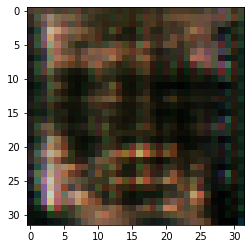

In [12]:
prediccion_falsa = np.array([])
error_d_acumulado = np.array([])

for i in range(1,N_ITS+1):
    start = time.time()
    print("Comenzando Epoca " + str(i), end = "")

    # Crear un "batch" de imágenes falsas y otro con imágenes reales
    ruido = np.random.normal(0,1,[TAM_LOTE,TAM_ENTRADA])
    batch_falsas = generador.predict(ruido)
    
    idx = np.random.randint(low=0, high=x_train.shape[0],size=TAM_LOTE)
    batch_reales = x_train[idx]
    
    #la unificacion del batch de entrenamiento es lo que logra que el modelo aprenda
    batch = np.concatenate(( batch_reales, batch_falsas))
    valores = np.concatenate((np.ones(TAM_LOTE)*0.9, np.zeros(TAM_LOTE)))
    
    print(".", end = "")
    
    # Entrenar discriminador con imagener falsas y reales, y en cada
    # caso calcular el error
    discriminador.trainable = True

    #las reales le digo como resultado 1 con np.ones
    #las falsas le digo como resultado 0 con np.zeros
    #dError_reales = discriminador.train_on_batch(batch_reales, np.ones(TAM_LOTE)*0.9) #El 0.9 ayuda a que converga mejor
    #dError_falsas = discriminador.train_on_batch(batch_falsas, np.zeros(TAM_LOTE))
    
    dError = discriminador.train_on_batch(batch, valores)
    
    error_d_acumulado = np.append(error_d_acumulado, dError)
    
    #congelo el discriminador
    discriminador.trainable = False

    print(".", end = "")
    
    # Entrenar GAN: se generará ruido aleatorio y se presentará a la GAN
    # como si fuesen imagenes reales
    ruido = np.random.normal(0,1,[TAM_LOTE,TAM_ENTRADA])
    gError = gan.train_on_batch(ruido, np.ones(TAM_LOTE))
    
    print(".", end = "")
    
    #Cada 100 iteraciones vamos a guardar una imagen
    if i==1 or i%100 == 0:
        ruido = np.random.normal(0,1,TAM_ENTRADA)
        ruido = np.array([ruido])
        resultado = generador.predict(ruido)
        resultado = resultado * 0.5 + 0.5
        plt.imshow(resultado.reshape(TAM_IMG,TAM_IMG,3))
        plt.savefig("resultadosGAN-3/r"+ str(i) + ".png")
    
    ruido = np.random.normal(0,1,TAM_ENTRADA)
    ruido = np.array([ruido])
    resultado = generador.predict(ruido)
    
    ppp = discriminador(resultado)
    prediccion_falsa = np.append(prediccion_falsa, ppp)
    end = time.time()
    print(" Fin")
    print("Tiempo transcurrido: ",end - start)
    print("prediccion de ruido: ",ppp)
    print("===================================================================")


<AxesSubplot:>

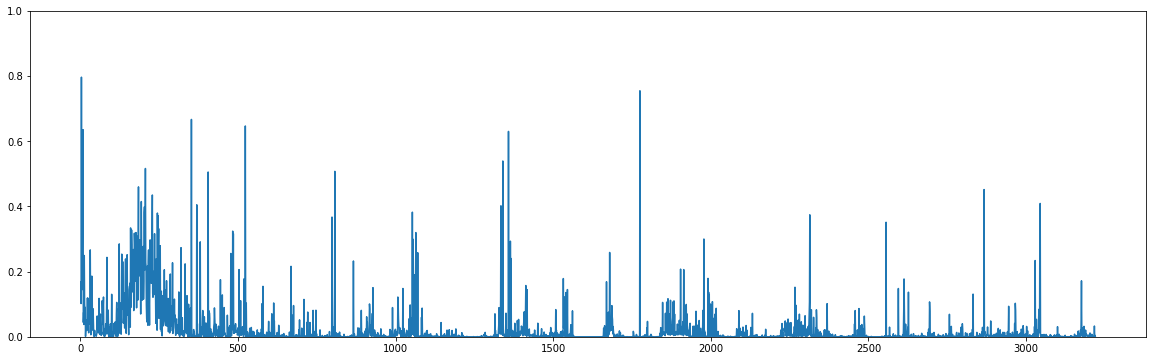

In [19]:
import seaborn as sns

t = np.linspace(1, len(prediccion_falsa), len(prediccion_falsa))

plt.figure(figsize=(20, 6))
plt.ylim(0, 1)
sns.lineplot(x=t, y=prediccion_falsa)
#sns.lineplot(x=t, y=error_acumulado_batch_reales, label="batch_reales", linewidth=3)
#sns.lineplot(x=t, y=error_acumulado_gError, label="gError", linewidth=3)


<AxesSubplot:>

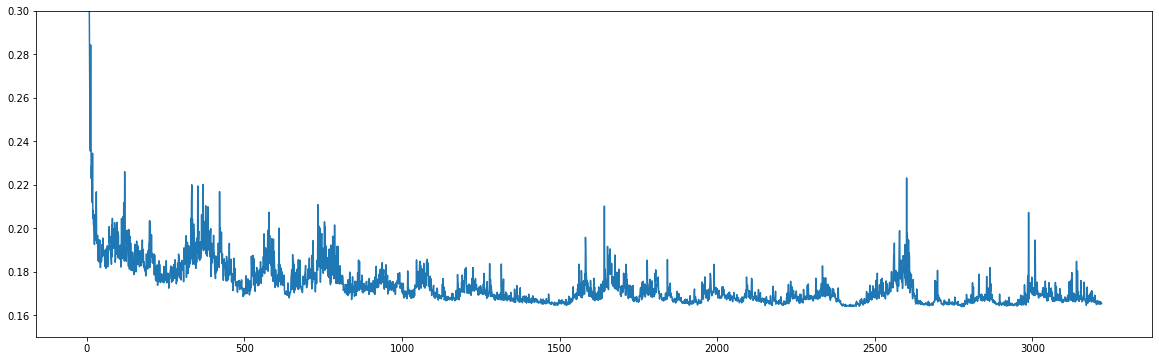

In [24]:
t = np.linspace(1, len(error_d_acumulado), len(error_d_acumulado))

plt.figure(figsize=(20, 6))
plt.ylim(0.15, 0.3)
sns.lineplot(x=t, y=error_d_acumulado)

tf.Tensor([[0.00055325]], shape=(1, 1), dtype=float32)


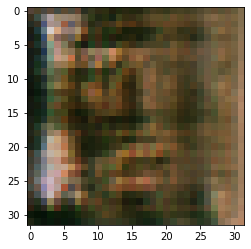

In [33]:
ruido = np.random.normal(0,1,TAM_ENTRADA)
ruido =np.array([ruido])

resultado = generador.predict(ruido)

print(discriminador(resultado))


resultado = resultado.reshape(TAM_IMG,TAM_IMG,3)

visualizar_imagen(resultado)

Al unificar los batch antes de entrenar se logra que el modelo empiece a aprender algo. Antes, al estar separados, el modelo aprendia a identificar las imagenes reales para luego borrar lo aprendido con las imagenes falsas, por ello no se llegaba a nada

El modelo pasa de generar una silueta a nada especifico de forma ciclica, hay que modificar los parametros de aprendizaje a ver si se logra mejorar